***Importing Required Libraries for Data Analysis***

In [143]:
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

***Importing Required Libraries for Exploratory Data Analysis / Visualization***

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline

***Importing Data for Analysis:***
- Train_values.csv will be renamed to X.
- Train_labels.csv will be renamed to y.
- Test_values.csv will be renamed to X_holdout.

A full training set including label data (all_train) will be created by merging the training labels on to the values.
This will primarily be used for exploratory data analysis.

A complete set including the holdout set (all_X) will be created by concatenating the training set to the holdout set.
This will reduce required preprocessing activities.

In [145]:
X_holdout = pd.read_csv('test_values.csv')
X = pd.read_csv('train_values.csv')
y = pd.read_csv('train_labels.csv')
all_train = X.merge(y, left_on='building_id', right_on='building_id')
all_X = pd.concat([X, X_holdout], axis=0)

Once all data has been merged, it is safe to drop the building_id; this field only served the purpose of merging datasets and is not predictive.

In [146]:
all_X = all_X.drop(['building_id'], axis=1)
all_train = all_train.drop(['building_id'], axis=1)

In [147]:
all_train.dtypes

geo_level_1_id                              int64
geo_level_2_id                              int64
geo_level_3_id                              int64
count_floors_pre_eq                         int64
age                                         int64
area                                        int64
height                                      int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64
has_superstructure_cement_mortar_stone      int64
has_superstructure_mud_mortar_brick         int64
has_superstructure_cement_mortar_brick      int64


***Correcting for inaccurate data types.***

Looking into the types of the variables reveals that:
- The boolean (True / False) categorical variables have been categorized as 'int64'.
- The geographical categorical variables have been miscategorized as integers.
- The 4 numeric variables (count_floors_pre_eq, age, area and height) are all integers.
- The only 2 floats are count_families and has_secondary_use, which may be misclassified.

In [148]:
print('Unique values for count_families: {}'.format(np.unique(all_X['count_families'].values)))
print('Unique values for has_secondary_use: {}'.format(np.unique(all_X['has_secondary_use'].values)))
print('Unique values for count_floors_pre_eq: {}'.format(np.unique(all_X['count_floors_pre_eq'].values)))

Unique values for count_families: [ 0.  1.  2.  3.  4.  5.  6.  7.]
Unique values for has_secondary_use: [ 0.  1.]
Unique values for count_floors_pre_eq: [1 2 3 4 5 6 7 9]


Checking unique values confirms that float values were miscoded.
These will be changed to int64.

In [149]:
all_train['count_families'] = all_train['count_families'].astype('int64')
all_X['count_families'] = all_X['count_families'].astype('int64')
all_train['has_secondary_use'] = all_train['has_secondary_use'].astype('int64')
all_X['has_secondary_use'] = all_X['has_secondary_use'].astype('int64')

Geographical categorical categories will be reclassified properly as categorical.

Other object categories will also be reclassified as categorical for ease of encoding later.

The damage type (y) will be treated as numeric for the purpose of data analysis as it is an ordinal variable.

In [150]:
categorical_columns = ['geo_level_1_id','geo_level_2_id','geo_level_3_id',
                       'land_surface_condition','foundation_type','roof_type',
                       'ground_floor_type','other_floor_type','position',
                       'plan_configuration','legal_ownership_status']

non_geo_cat_columns =  ['land_surface_condition','foundation_type','roof_type',
                       'ground_floor_type','other_floor_type','position',
                       'plan_configuration','legal_ownership_status']

In [151]:
for col in categorical_columns:
    all_X[col] = all_X[col].astype('category')
    all_train[col] = all_train[col].astype('category')

In [152]:
all_train.dtypes

geo_level_1_id                            category
geo_level_2_id                            category
geo_level_3_id                            category
count_floors_pre_eq                          int64
age                                          int64
area                                         int64
height                                       int64
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                 int64
has_superstructure_mud_mortar_stone          int64
has_superstructure_stone_flag                int64
has_superstructure_cement_mortar_stone       int64
has_superstructure_mud_mortar_brick          int64
has_superstructure_cement_morta

In [153]:
boolean_variables = ['has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',
                     'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',
                     'has_superstructure_cement_mortar_brick','has_superstructure_timber',
                     'has_superstructure_bamboo','has_superstructure_rc_non_engineered','has_superstructure_rc_engineered',
                     'has_superstructure_other','has_secondary_use','has_secondary_use_agriculture',
                     'has_secondary_use_hotel','has_secondary_use_rental','has_secondary_use_institution',
                     'has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post',
                     'has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other']

superstructure_variables = ['has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',
                     'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',
                     'has_superstructure_cement_mortar_brick','has_superstructure_timber',
                     'has_superstructure_bamboo','has_superstructure_rc_non_engineered','has_superstructure_rc_engineered',
                     'has_superstructure_other','damage_grade']

secuse_variables = ['has_secondary_use_agriculture',
                     'has_secondary_use_hotel','has_secondary_use_rental','has_secondary_use_institution',
                     'has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post',
                     'has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other','damage_grade']

integer_variables = ['count_floors_pre_eq','age','area','height','count_families']

***Exploratory Data Analysis***

First, I'll take a look into some summary statistics on the non-binary variables.

In [154]:
all_train[integer_variables].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,count_floors_pre_eq,age,area,height,count_families
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.146700,25.393500,38.438100,4.653100,0.984600
std,0.736365,64.482893,21.265883,1.792842,0.423297
min,1.000000,0.000000,6.000000,1.000000,0.000000
1%,1.000000,0.000000,11.000000,1.000000,0.000000
5%,1.000000,0.000000,16.000000,2.000000,0.000000
25%,2.000000,10.000000,26.000000,4.000000,1.000000
50%,2.000000,15.000000,34.000000,5.000000,1.000000
75%,3.000000,30.000000,44.000000,5.000000,1.000000
95%,3.000000,60.000000,74.000000,8.000000,2.000000


In [155]:
all_train[boolean_variables].sum()

has_superstructure_adobe_mud               897
has_superstructure_mud_mortar_stone       7626
has_superstructure_stone_flag              299
has_superstructure_cement_mortar_stone     190
has_superstructure_mud_mortar_brick        688
has_superstructure_cement_mortar_brick     725
has_superstructure_timber                 2561
has_superstructure_bamboo                  877
has_superstructure_rc_non_engineered       400
has_superstructure_rc_engineered           138
has_superstructure_other                   141
has_secondary_use                         1086
has_secondary_use_agriculture              673
has_secondary_use_hotel                    294
has_secondary_use_rental                    64
has_secondary_use_institution                7
has_secondary_use_school                     7
has_secondary_use_industry                   8
has_secondary_use_health_post                2
has_secondary_use_gov_office                 2
has_secondary_use_use_police                 1
has_secondary

***Categorical Variable Investigation***

In [156]:
non_geo_cat_columns =  ['land_surface_condition','foundation_type','roof_type',
                       'ground_floor_type','other_floor_type','position',
                       'plan_configuration','legal_ownership_status']

for col in non_geo_cat_columns:
    print('Unique values for {}: {}'.format(col, np.unique(all_X[col].values)))

Unique values for land_surface_condition: ['2f15' '808e' 'd502']
Unique values for foundation_type: ['337f' '467b' '6c3e' '858b' 'bb5f']
Unique values for roof_type: ['67f9' '7e76' 'e0e2']
Unique values for ground_floor_type: ['467b' 'b1b4' 'b440' 'bb5f' 'e26c']
Unique values for other_floor_type: ['441a' '67f9' '9eb0' 'f962']
Unique values for position: ['1787' '3356' 'bcab' 'bfba']
Unique values for plan_configuration: ['0448' '1442' '3fee' '6e81' '84cf' '8e3f' 'a779' 'cb88' 'd2d9']
Unique values for legal_ownership_status: ['ab03' 'bb5f' 'c8e1' 'cae1']


In [157]:
geo_cat_columns = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']

for col in geo_cat_columns:
    print('Unique values for {}: {}'.format(col, np.unique(all_train[col].values).shape[0]))


Unique values for geo_level_1_id: 31
Unique values for geo_level_2_id: 1137
Unique values for geo_level_3_id: 5172


***Damage Grade Distribution***

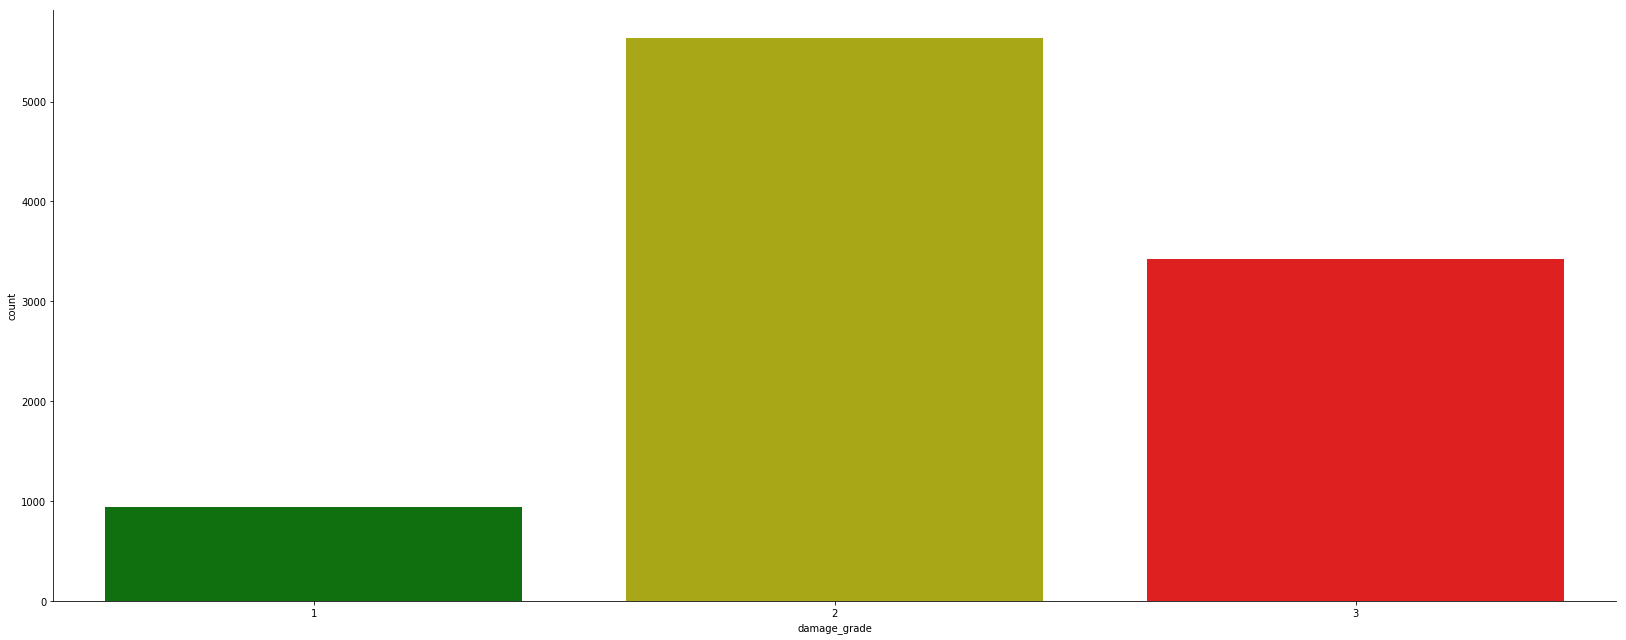

In [158]:
sns.factorplot(x='damage_grade', data=all_train, kind='count', size=9, aspect=2.5, palette=['g','y','r'])

In [159]:
damage_count = pd.pivot_table(data=all_train, index='damage_grade', values='age', aggfunc=len)
damage_count['distribution'] = damage_count['age'] / 10000
print(damage_count)

               age  distribution
damage_grade                    
1              938        0.0938
2             5636        0.5636
3             3426        0.3426


Overall distribution shows that 9.4% are damage grade 1 (low damage), 56,3% are grade 2 (medium damage) and 34.3% are grade 3 (high damage).

***Outlier Issues***
- The age column shows a mean of 25.4, but has a max of 995 with a 75th percentile at 30.
- The area column shows a mean of 38.4, but has a max of 425 with 75th percentile at 44.
- The height column shows a mean of 4.65, but has a max of 30 with median and 75th percentile at 5.

***Small Sample Issues***
- Of all the secondary use columns, only hotel has over a 1% share of the total number of buildings.

***Age Column Investigation***

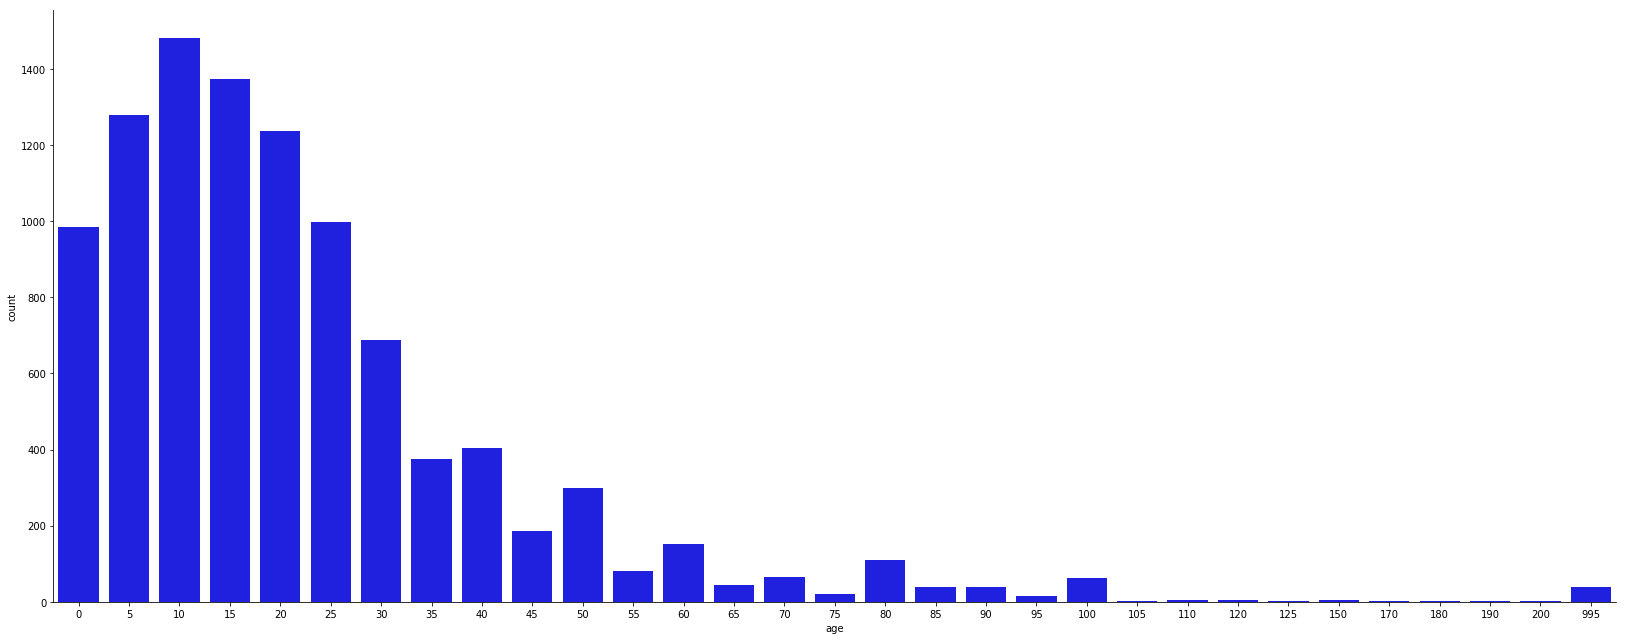

In [160]:
sns.factorplot(x='age', data=all_train, kind='count', size=9, aspect=2.5, color='blue')
plt.show()

In [161]:
age_grp = all_train.groupby('age', axis=0, as_index=False)['damage_grade'].agg({'count': len, 'damage_mean':np.mean})
age_grp1 = all_train[all_train['damage_grade'] == 1].groupby('age', axis=0, as_index=False)['damage_grade'].count()
age_grp2 = all_train[all_train['damage_grade'] == 2].groupby('age', axis=0, as_index=False)['damage_grade'].count()
age_grp3 = all_train[all_train['damage_grade'] == 3].groupby('age', axis=0, as_index=False)['damage_grade'].count()
age_full = pd.merge(age_grp, age_grp1, on='age', how='left')
age_full = pd.merge(age_full, age_grp2, on='age', how='left')
age_full = pd.merge(age_full, age_grp3, on='age', how='left')
age_full = age_full.fillna(0)
age_full.columns = ['age','count','damage_mean','damage1','damage2','damage3']

print(age_full)

    age  count  damage_mean  damage1  damage2  damage3
0     0    984     1.977642    271.0    464.0    249.0
1     5   1279     2.111806    198.0    740.0    341.0
2    10   1481     2.230925    164.0    811.0    506.0
3    15   1373     2.263656    104.0    803.0    466.0
4    20   1236     2.311489     77.0    697.0    462.0
5    25    999     2.317317     54.0    574.0    371.0
6    30    688     2.350291     25.0    397.0    266.0
7    35    375     2.365333     14.0    210.0    151.0
8    40    405     2.362963     12.0    234.0    159.0
9    45    185     2.367568      6.0    105.0     74.0
10   50    298     2.375839      4.0    178.0    116.0
11   55     82     2.329268      0.0     55.0     27.0
12   60    152     2.401316      2.0     87.0     63.0
13   65     45     2.377778      1.0     26.0     18.0
14   70     66     2.378788      0.0     41.0     25.0
15   75     21     2.333333      1.0     12.0      8.0
16   80    111     2.423423      2.0     60.0     49.0
17   85   

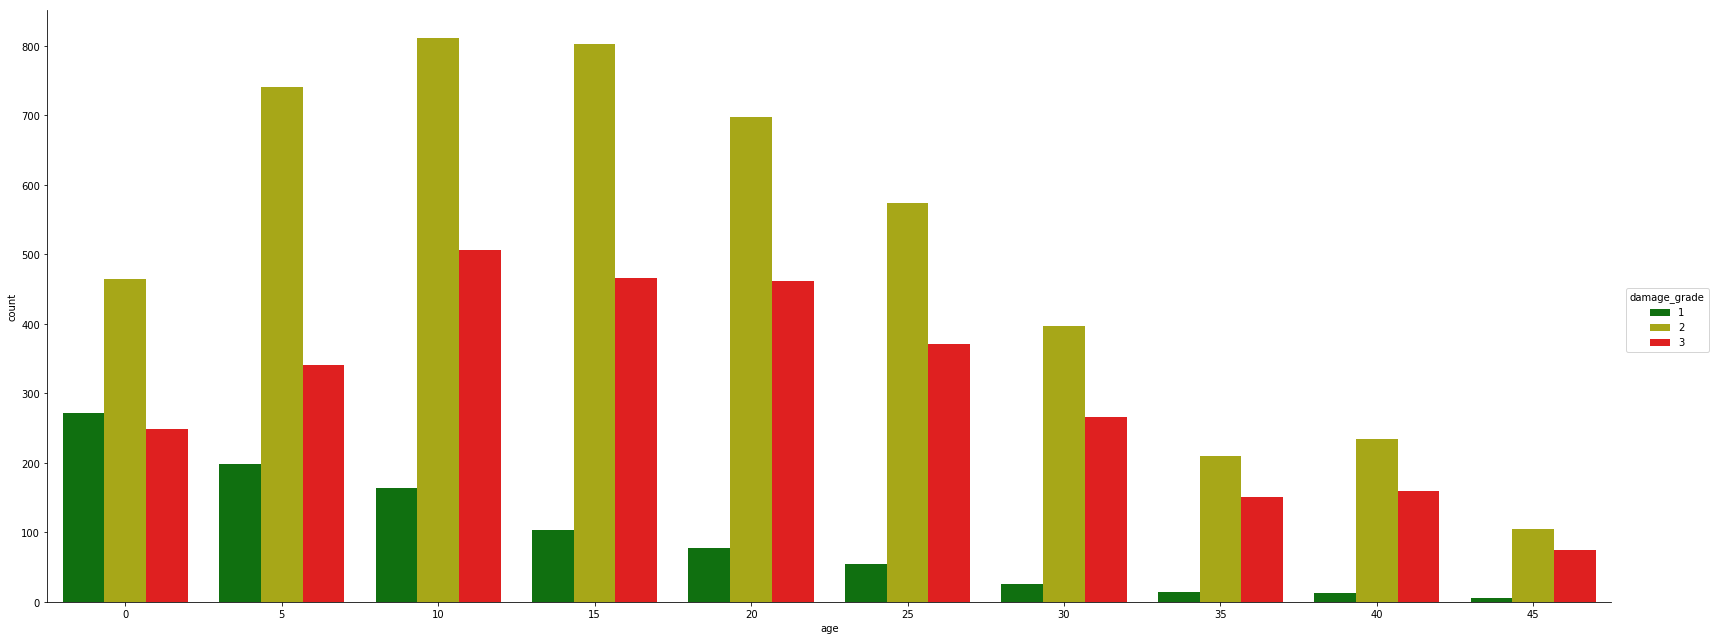

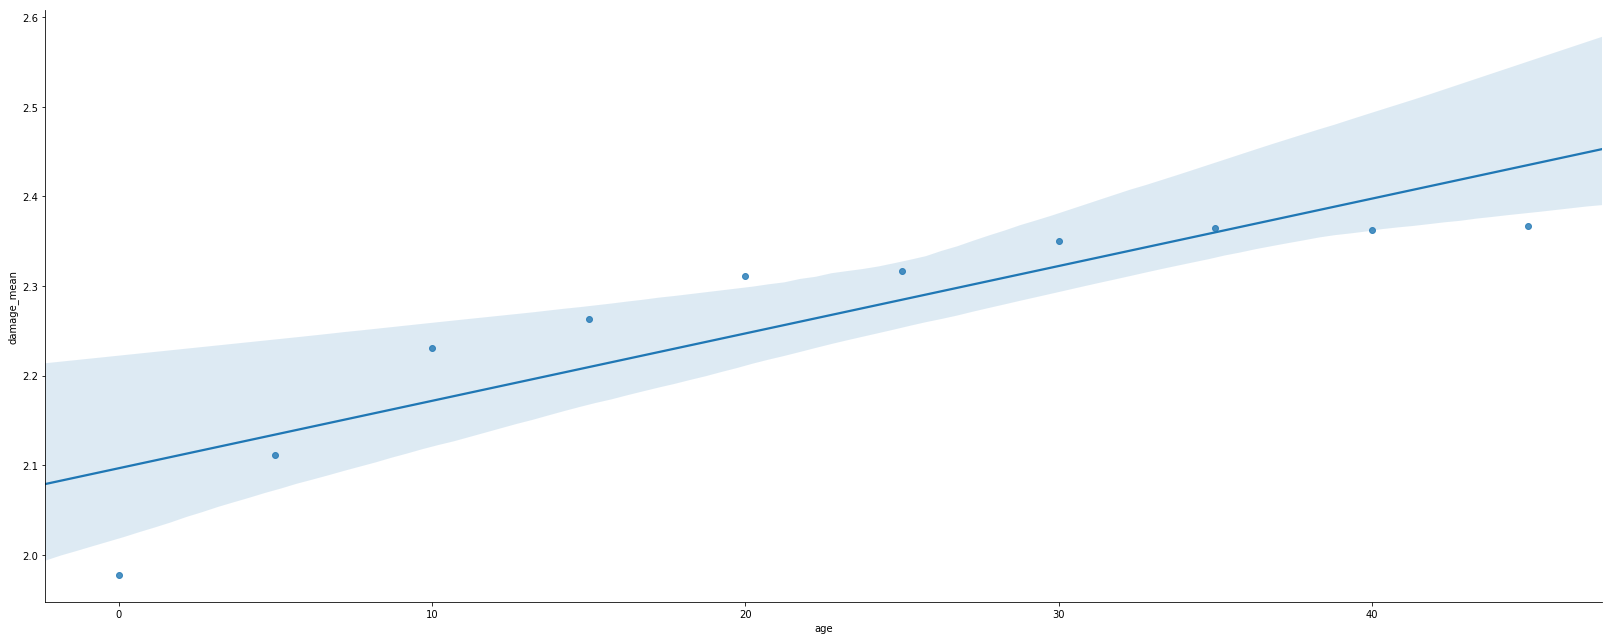

In [162]:
sns.factorplot(x='age', hue='damage_grade', data=all_train[all_train['age'] < 50], kind='count', size=9, aspect=2.5, palette=['g','y','r'])
sns.lmplot(x='age', y='damage_mean', data=age_grp[age_grp['age'] < 50], size=9, aspect=2.5)

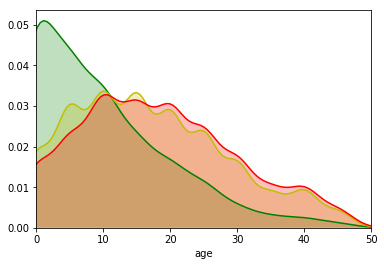

In [163]:
plt.xlim(0,50)
sns.distplot(all_train[all_train['age'] < 50].loc[all_train['damage_grade'] == 1,'age'], hist=False, color="g", kde_kws={"shade": True})
sns.distplot(all_train[all_train['age'] < 50].loc[all_train['damage_grade'] == 2,'age'], hist=False, color="y", kde_kws={"shade": True})
sns.distplot(all_train[all_train['age'] < 50].loc[all_train['damage_grade'] == 3,'age'], hist=False, color="r", kde_kws={"shade": True})
plt.show()

In [164]:
height_grp = all_train.groupby('height', axis=0, as_index=False)['damage_grade'].agg({'count': len, 'damage_mean':np.mean})
height_grp1 = all_train[all_train['damage_grade'] == 1].groupby('height', axis=0, as_index=False)['damage_grade'].count()
height_grp2 = all_train[all_train['damage_grade'] == 2].groupby('height', axis=0, as_index=False)['damage_grade'].count()
height_grp3 = all_train[all_train['damage_grade'] == 3].groupby('height', axis=0, as_index=False)['damage_grade'].count()
height_full = pd.merge(height_grp, height_grp1, on='height', how='left')
height_full = pd.merge(height_full, height_grp2, on='height', how='left')
height_full = pd.merge(height_full, height_grp3, on='height', how='left')
height_full = height_full.fillna(0)
height_full.columns = ['height','count','damage_mean','damage1','damage2','damage3']


print(height_full)

    height  count  damage_mean  damage1  damage2  damage3
0        1    123     2.154472     22.0     60.0     41.0
1        2    813     2.092251    164.0    410.0    239.0
2        3   1507     2.173192    202.0    842.0    463.0
3        4   2298     2.269365    159.0   1361.0    778.0
4        5   2820     2.289362    200.0   1604.0   1016.0
5        6   1355     2.339483     76.0    743.0    536.0
6        7    561     2.344029     23.0    322.0    216.0
7        8    216     2.189815     28.0    119.0     69.0
8        9    144     2.125000     24.0     78.0     42.0
9       10     53     2.150943      4.0     37.0     12.0
10      11     43     1.720930     16.0     23.0      4.0
11      12     42     1.928571      9.0     27.0      6.0
12      13      4     1.750000      1.0      3.0      0.0
13      14     11     1.818182      4.0      5.0      2.0
14      15      7     1.571429      4.0      2.0      1.0
15      16      1     1.000000      1.0      0.0      0.0
16      24    

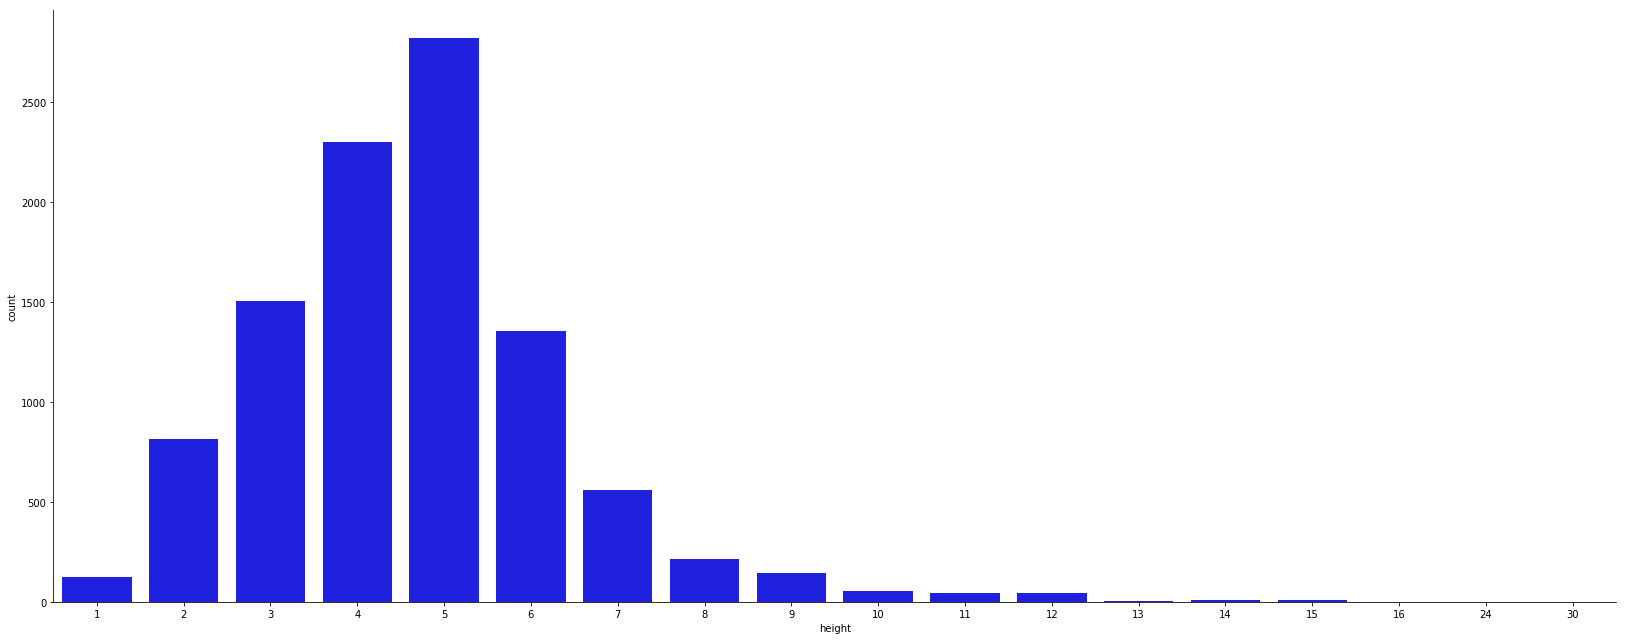

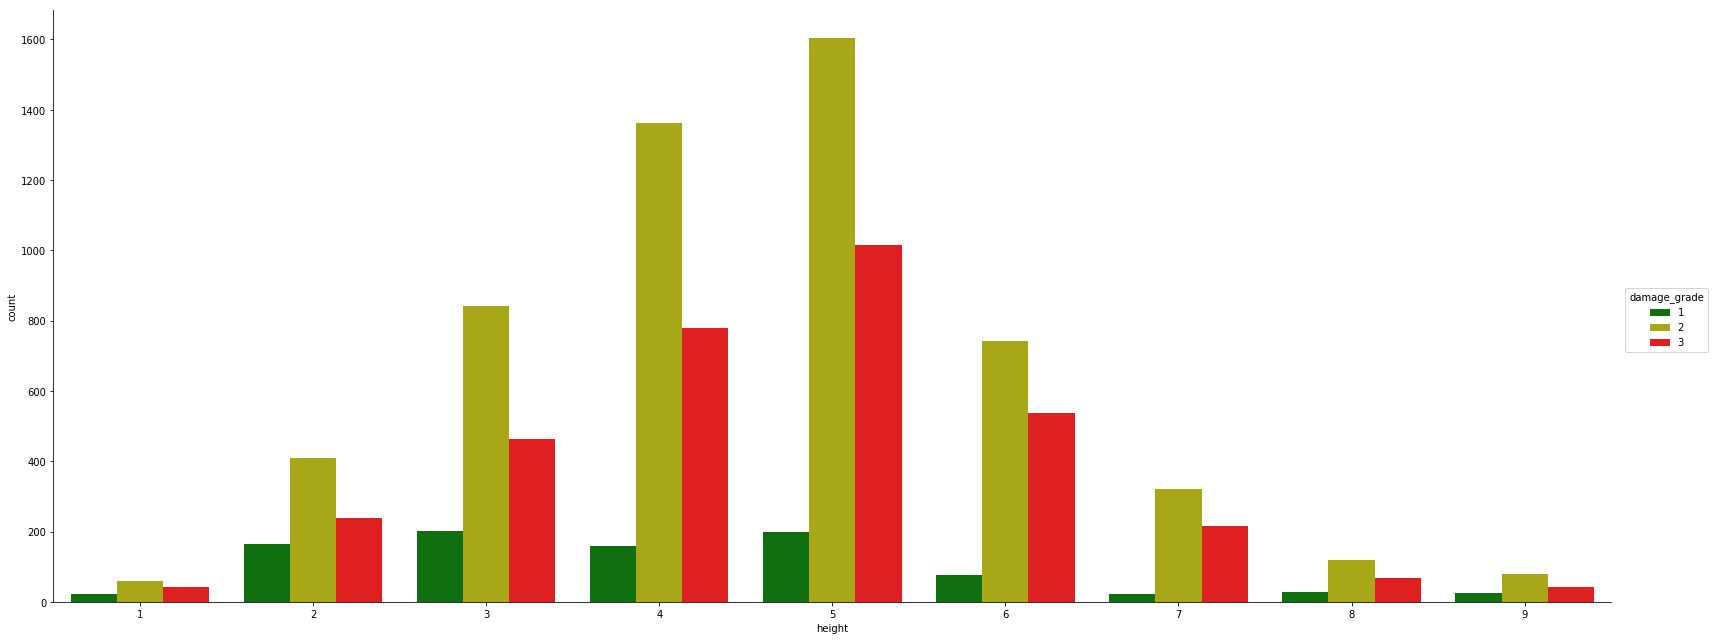

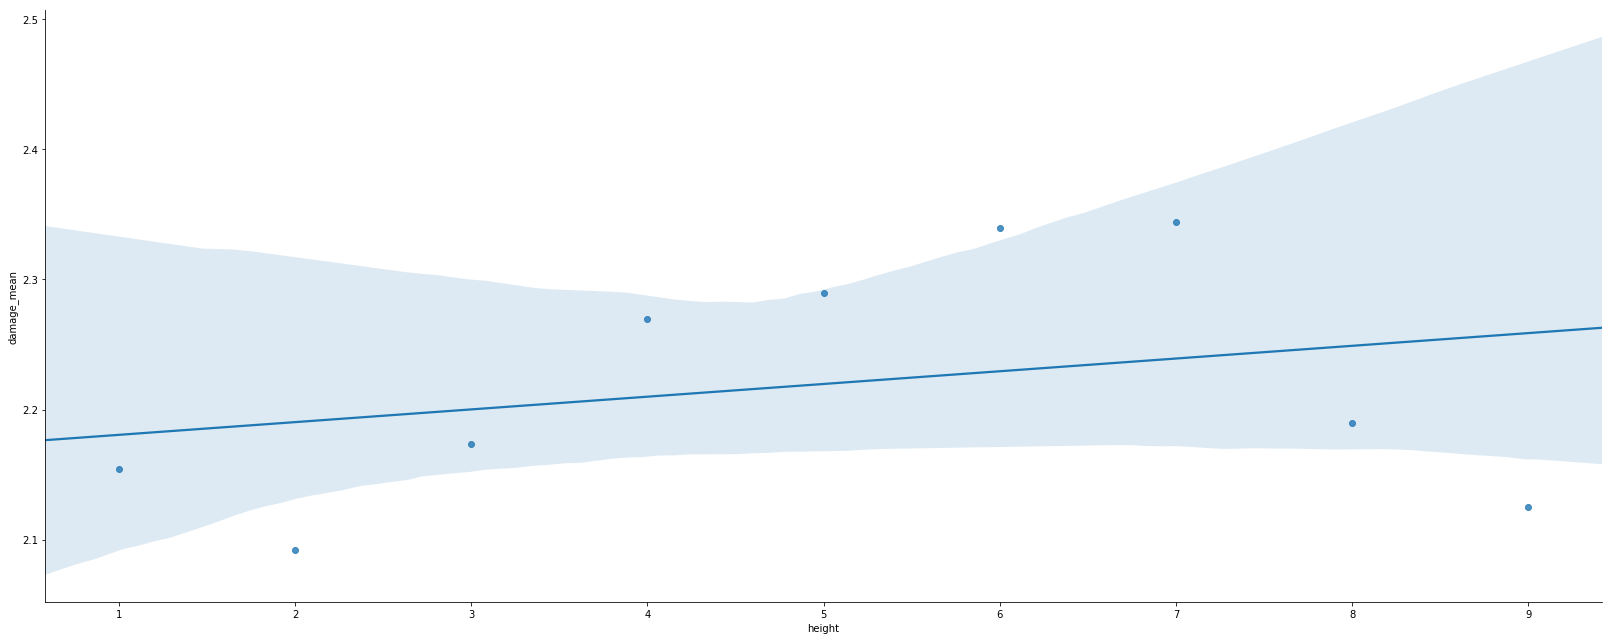

In [165]:
sns.factorplot(x='height', data=all_train, kind='count', size=9, aspect=2.5, color='blue')
sns.factorplot(x='height', hue='damage_grade', data=all_train[all_train['height'] < 10], kind='count', size=9, aspect=2.5, palette=['g','y','r'])
sns.lmplot(x='height', y='damage_mean', data=height_full[height_full['height'] < 10], size=9, aspect=2.5)
plt.show()

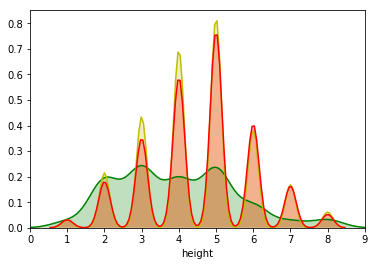

In [166]:
plt.xlim(0,9)
sns.distplot(all_train[all_train['height'] < 9].loc[all_train['damage_grade'] == 1,'height'], hist=False, color="g", kde_kws={"shade": True})
sns.distplot(all_train[all_train['height'] < 9].loc[all_train['damage_grade'] == 2,'height'], hist=False, color="y", kde_kws={"shade": True})
sns.distplot(all_train[all_train['height'] < 9].loc[all_train['damage_grade'] == 3,'height'], hist=False, color="r", kde_kws={"shade": True})
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


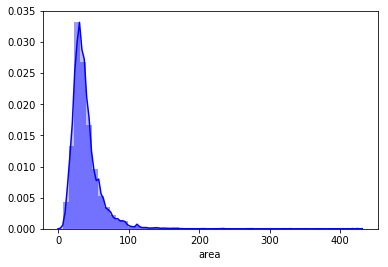

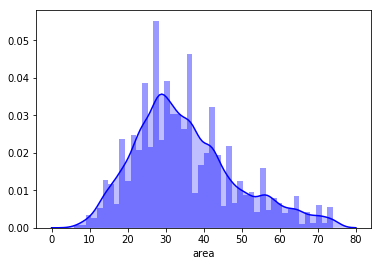

In [167]:

sns.distplot(all_train['area'], hist=True, color="b", kde_kws={"shade": True})
plt.show()
sns.distplot(all_train[all_train['area'] < 75].loc[:,'area'], hist=True, color="b", kde_kws={"shade": True})
plt.show()

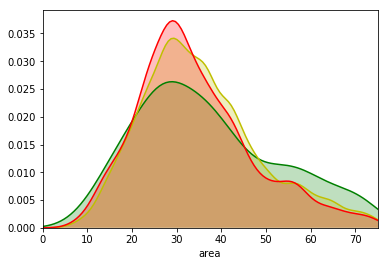

In [168]:
plt.xlim(0,75)
sns.distplot(all_train[all_train['area'] < 75].loc[all_train['damage_grade'] == 1,'area'], hist=False, color="g", kde_kws={"shade": True})
sns.distplot(all_train[all_train['area'] < 75].loc[all_train['damage_grade'] == 2,'area'], hist=False, color="y", kde_kws={"shade": True})
sns.distplot(all_train[all_train['area'] < 75].loc[all_train['damage_grade'] == 3,'area'], hist=False, color="r", kde_kws={"shade": True})
plt.show()

In [169]:
floors_grp = all_train.groupby('count_floors_pre_eq', axis=0, as_index=False)['damage_grade'].agg({'count': len, 'damage_mean':np.mean})
floors_grp1 = all_train[all_train['damage_grade'] == 1].groupby('count_floors_pre_eq', axis=0, as_index=False)['damage_grade'].count()
floors_grp2 = all_train[all_train['damage_grade'] == 2].groupby('count_floors_pre_eq', axis=0, as_index=False)['damage_grade'].count()
floors_grp3 = all_train[all_train['damage_grade'] == 3].groupby('count_floors_pre_eq', axis=0, as_index=False)['damage_grade'].count()
floors_full = pd.merge(floors_grp, floors_grp1, on='count_floors_pre_eq', how='left')
floors_full = pd.merge(floors_full, floors_grp2, on='count_floors_pre_eq', how='left')
floors_full = pd.merge(floors_full, floors_grp3, on='count_floors_pre_eq', how='left')
floors_full = floors_full.fillna(0)
floors_full.columns = ['count_floors_pre_eq','count','damage_mean','damage1','damage2','damage3']


print(floors_full)

   count_floors_pre_eq  count  damage_mean  damage1  damage2  damage3
0                    1   1521     2.075608    325.0    756.0    440.0
1                    2   5923     2.238562    482.0   3546.0   1895.0
2                    3   2235     2.416107     89.0   1127.0   1019.0
3                    4    224     2.129464     26.0    143.0     55.0
4                    5     87     2.057471     12.0     58.0     17.0
5                    6      8     1.625000      3.0      5.0      0.0
6                    7      1     1.000000      1.0      0.0      0.0
7                    9      1     2.000000      0.0      1.0      0.0


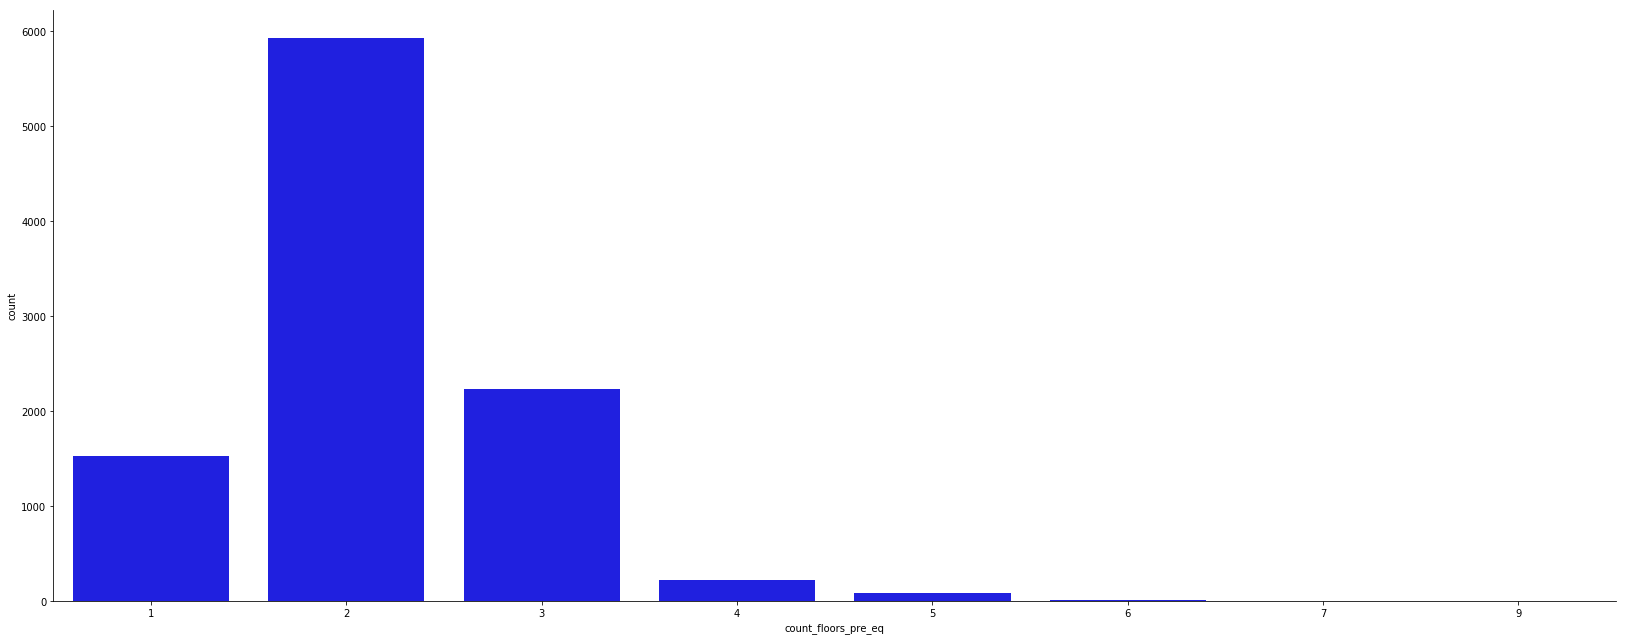

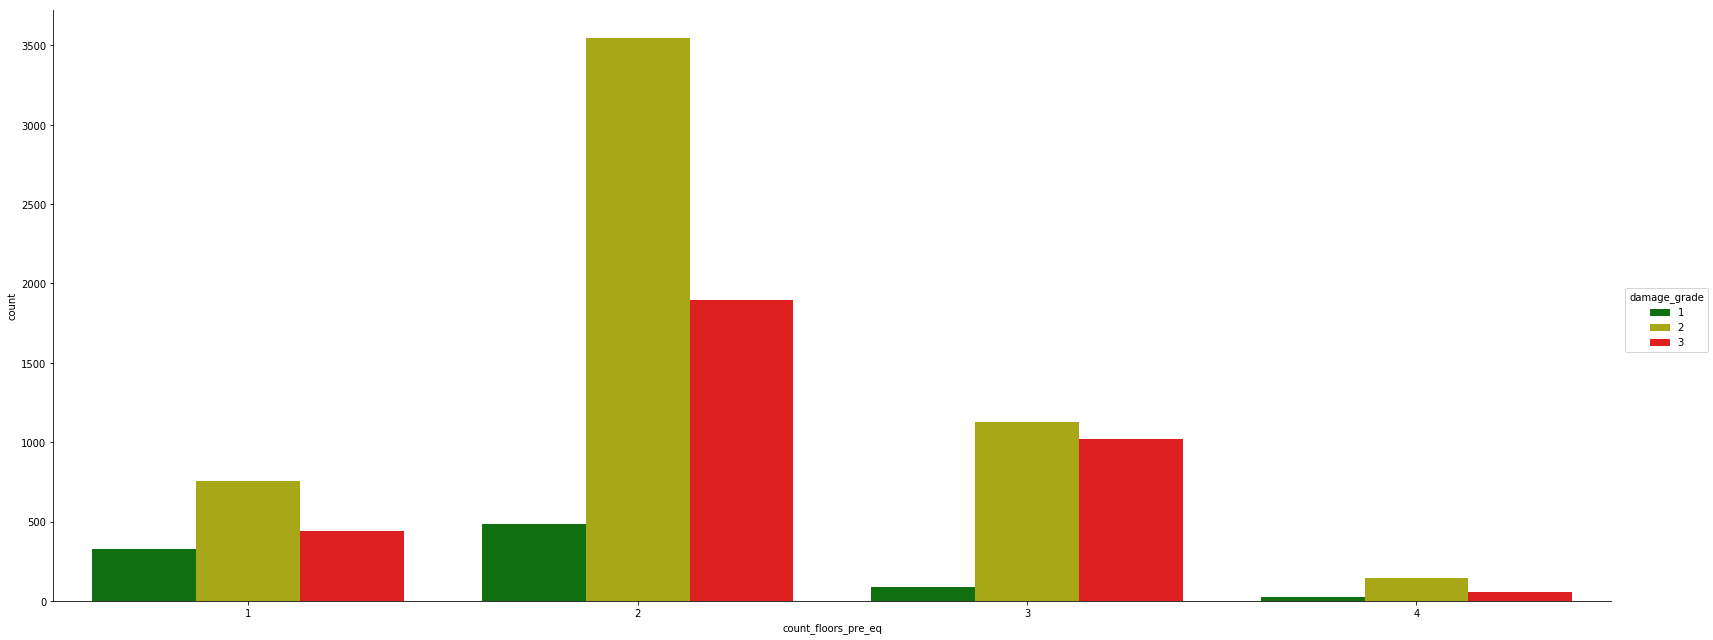

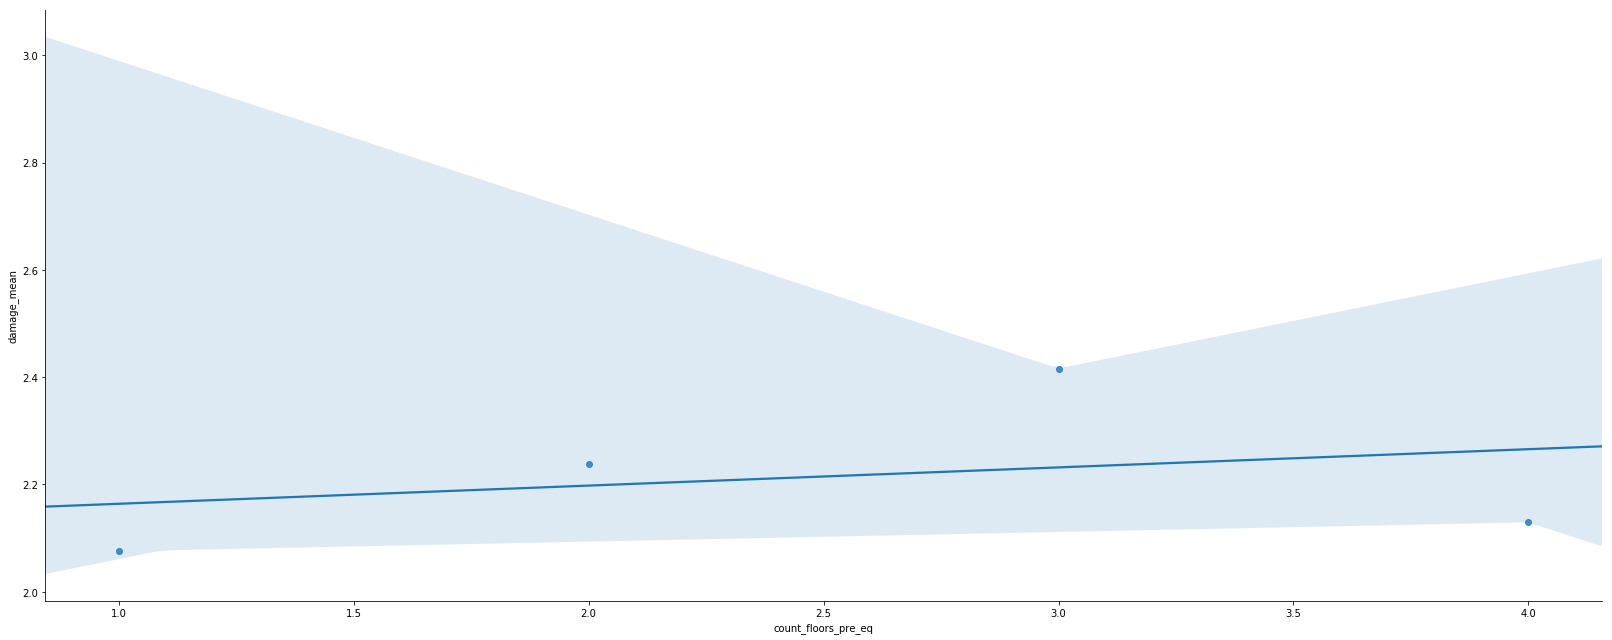

In [170]:
sns.factorplot(x='count_floors_pre_eq', data=all_train, kind='count', size=9, aspect=2.5, color='blue')
sns.factorplot(x='count_floors_pre_eq', hue='damage_grade', data=all_train[all_train['count_floors_pre_eq'] < 5], kind='count', size=9, aspect=2.5, palette=['g','y','r'])
sns.lmplot(x='count_floors_pre_eq', y='damage_mean', data=floors_full[floors_full['count_floors_pre_eq'] < 5], size=9, aspect=2.5, palette=['g','y','r'])
plt.show()

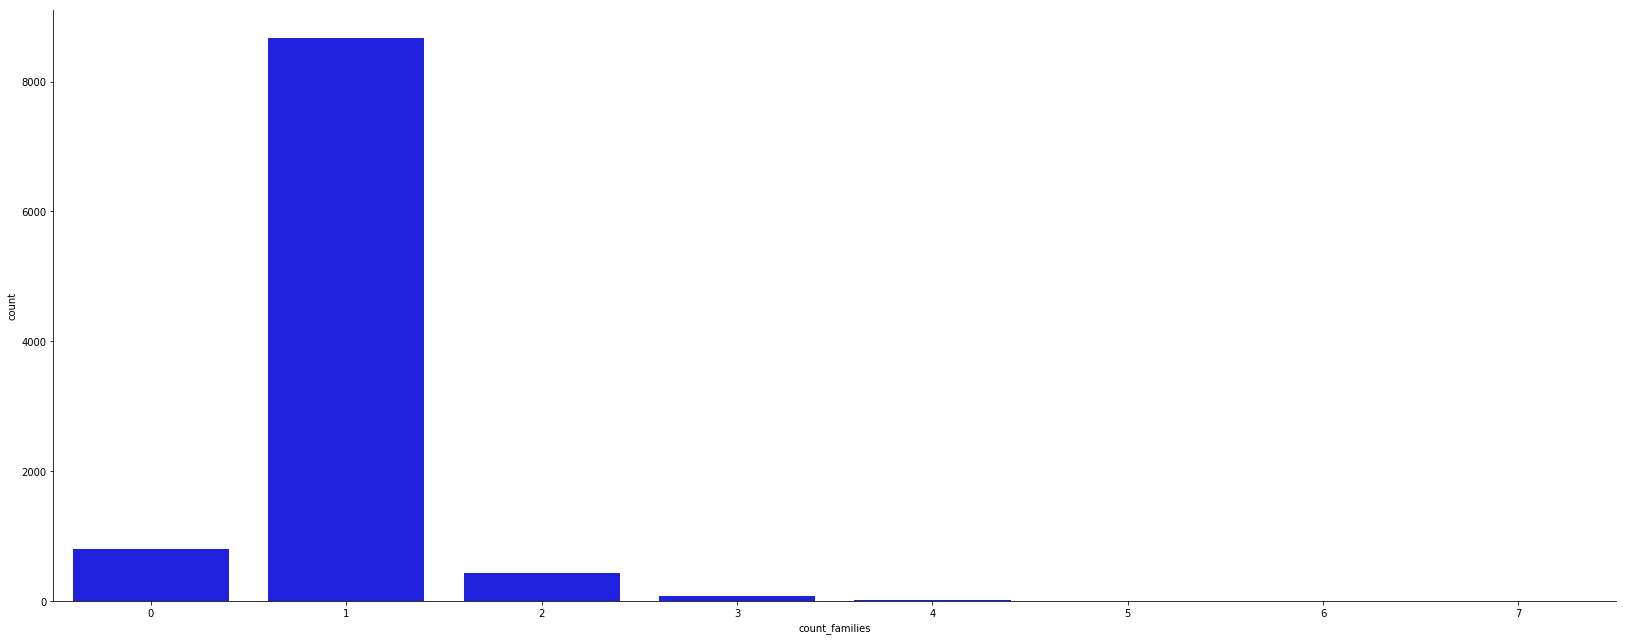

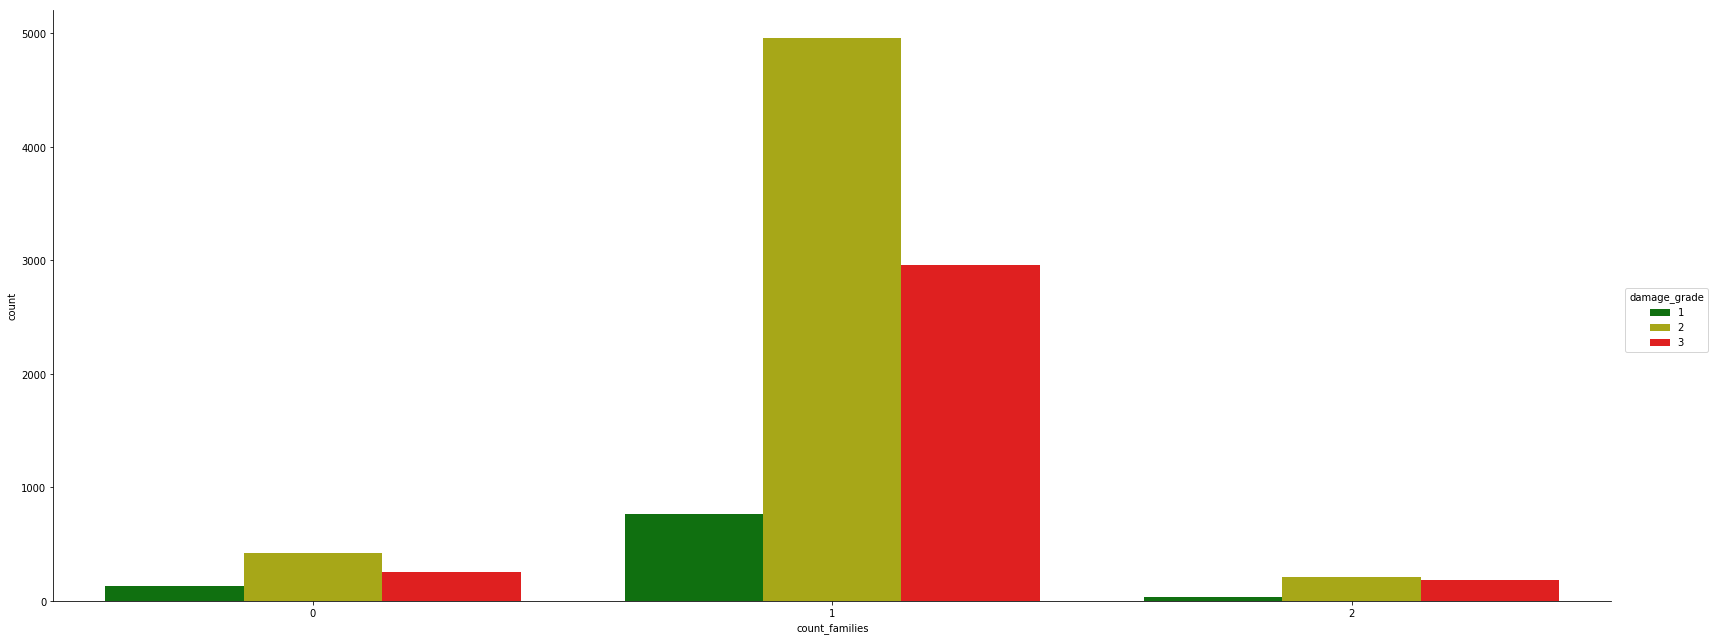

In [171]:
sns.factorplot(x='count_families', data=all_train, kind='count', size=9, aspect=2.5, color='blue')
sns.factorplot(x='count_families', hue='damage_grade', data=all_train[all_train['count_families'] < 3], kind='count', size=9, aspect=2.5, palette=['g','y','r'])
plt.show()

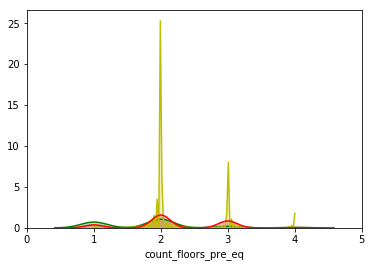

In [172]:
plt.xlim(0,5)
sns.distplot(all_train[all_train['count_floors_pre_eq'] < 5].loc[all_train['damage_grade'] == 1,'count_floors_pre_eq'], hist=False, color="g", kde_kws={"shade": True})
sns.distplot(all_train[all_train['count_floors_pre_eq'] < 5].loc[all_train['damage_grade'] == 2,'count_floors_pre_eq'], hist=False, color="y", kde_kws={"shade": True})
sns.distplot(all_train[all_train['count_floors_pre_eq'] < 5].loc[all_train['damage_grade'] == 3,'count_floors_pre_eq'], hist=False, color="r", kde_kws={"shade": True})
plt.show()

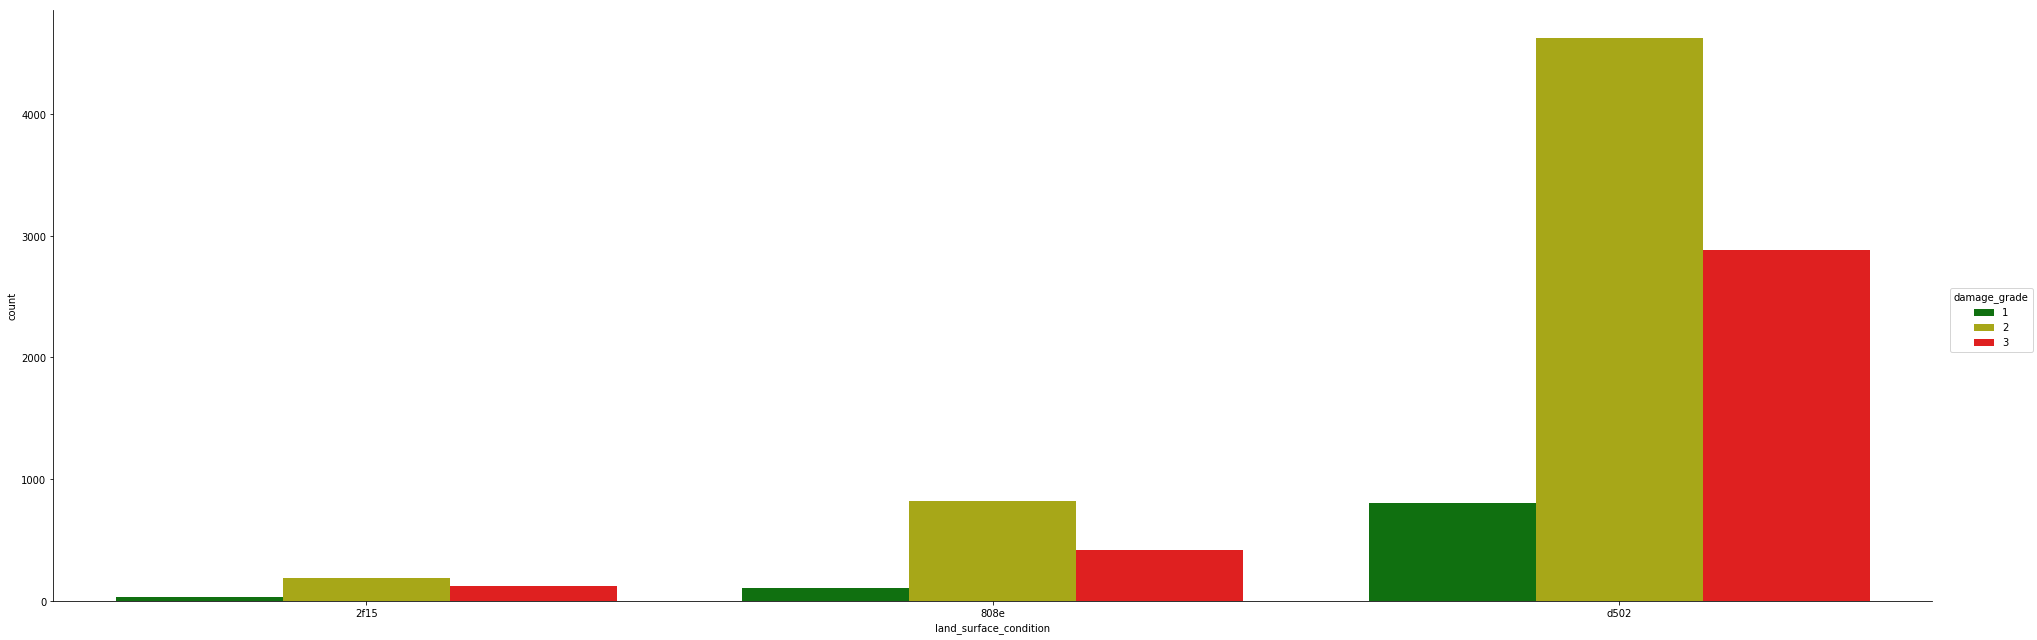

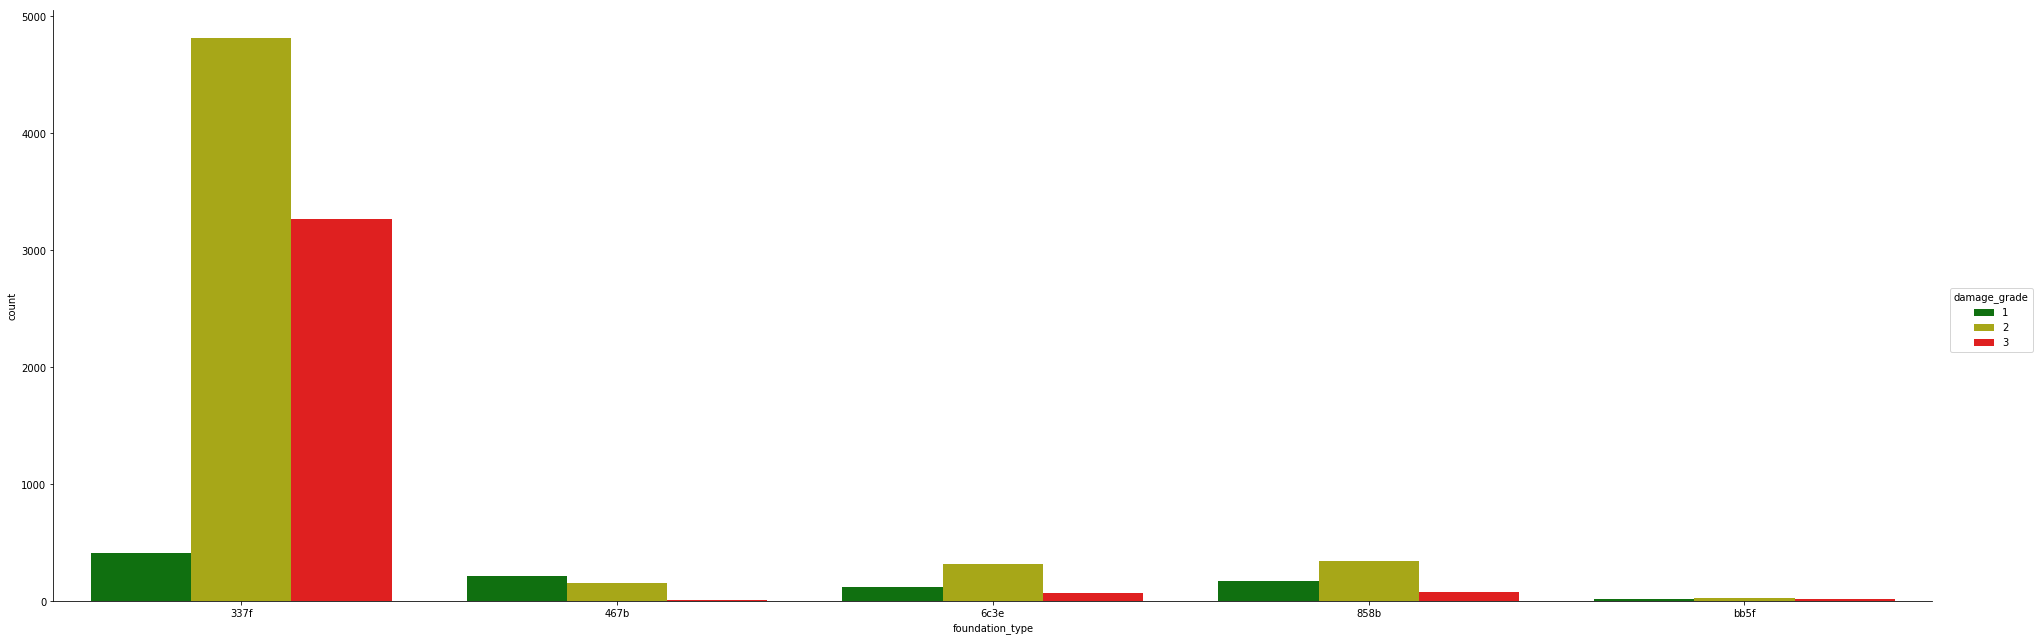

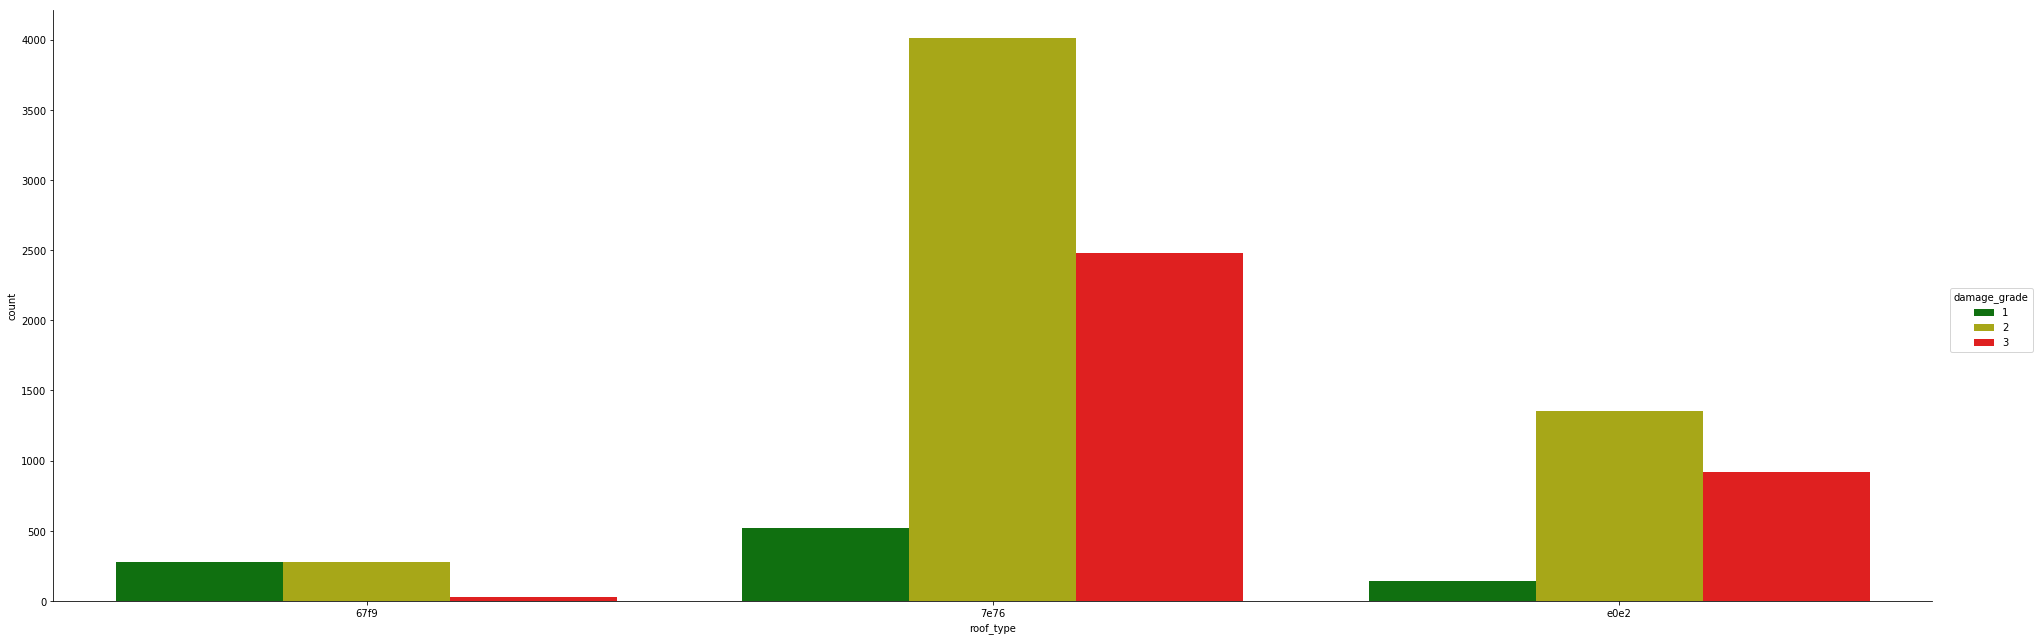

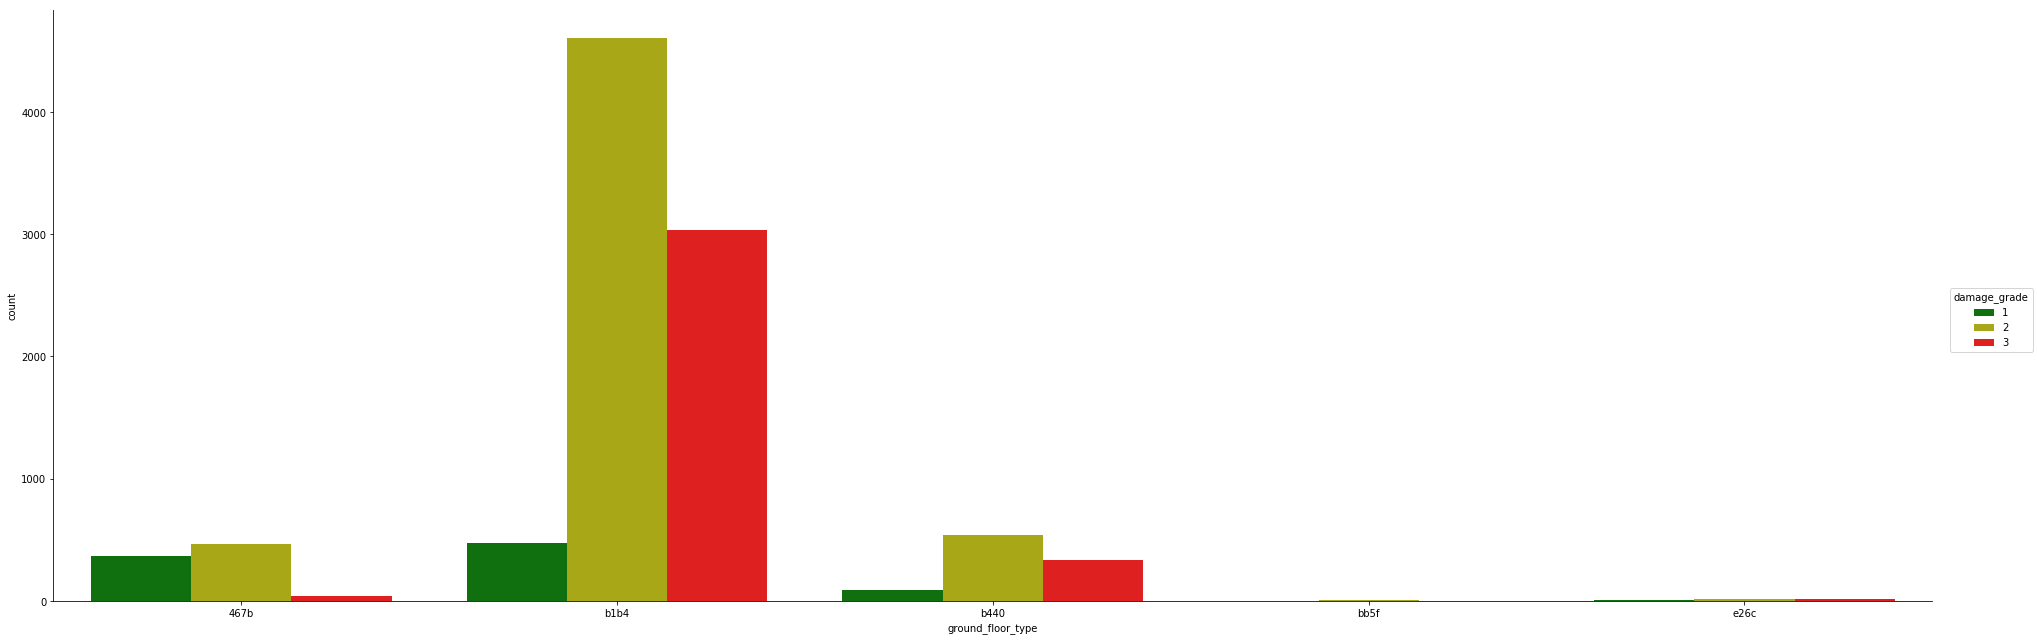

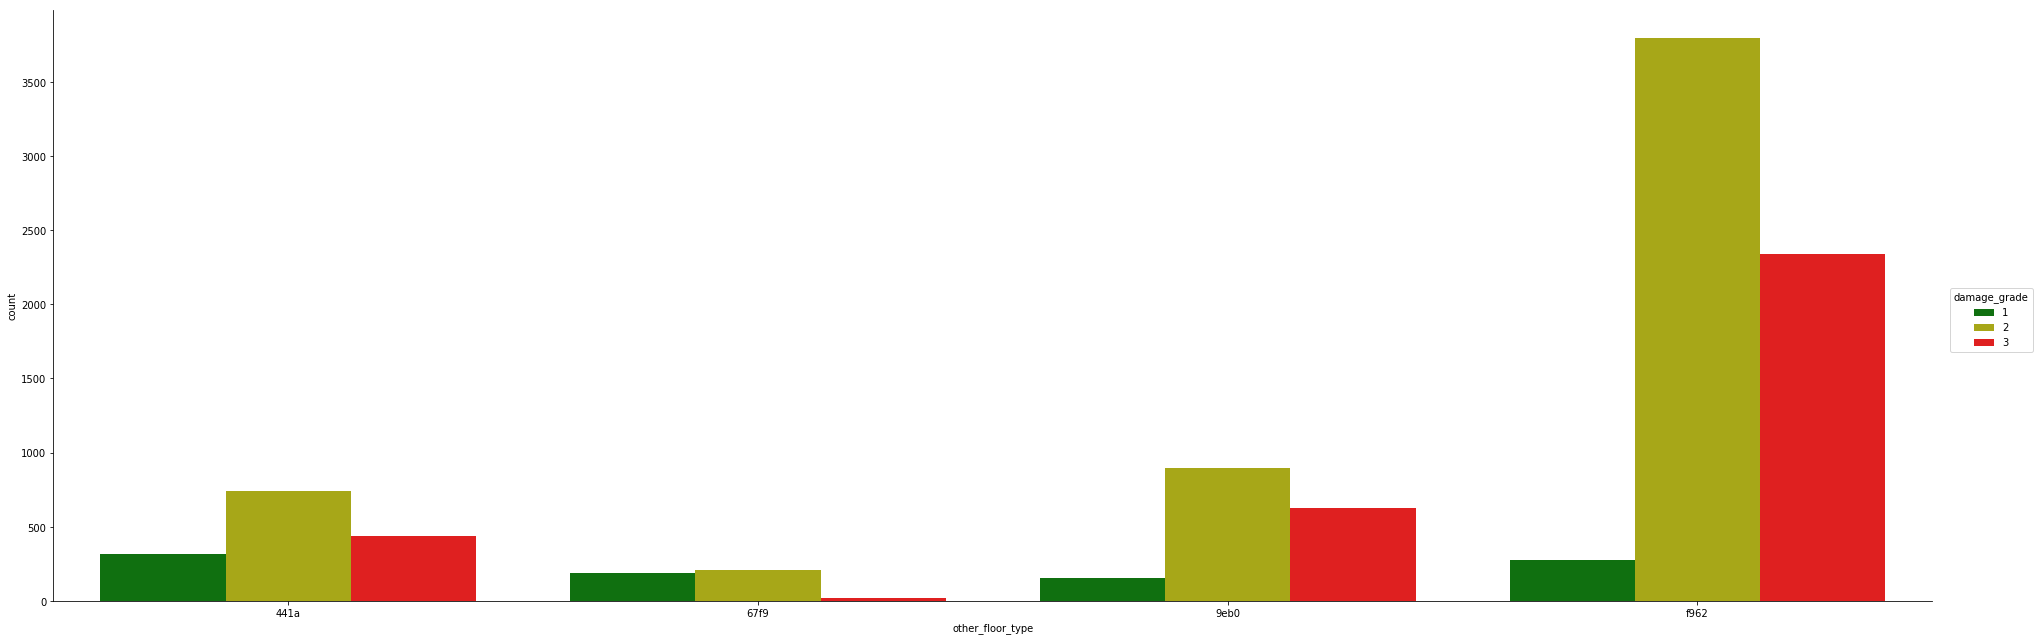

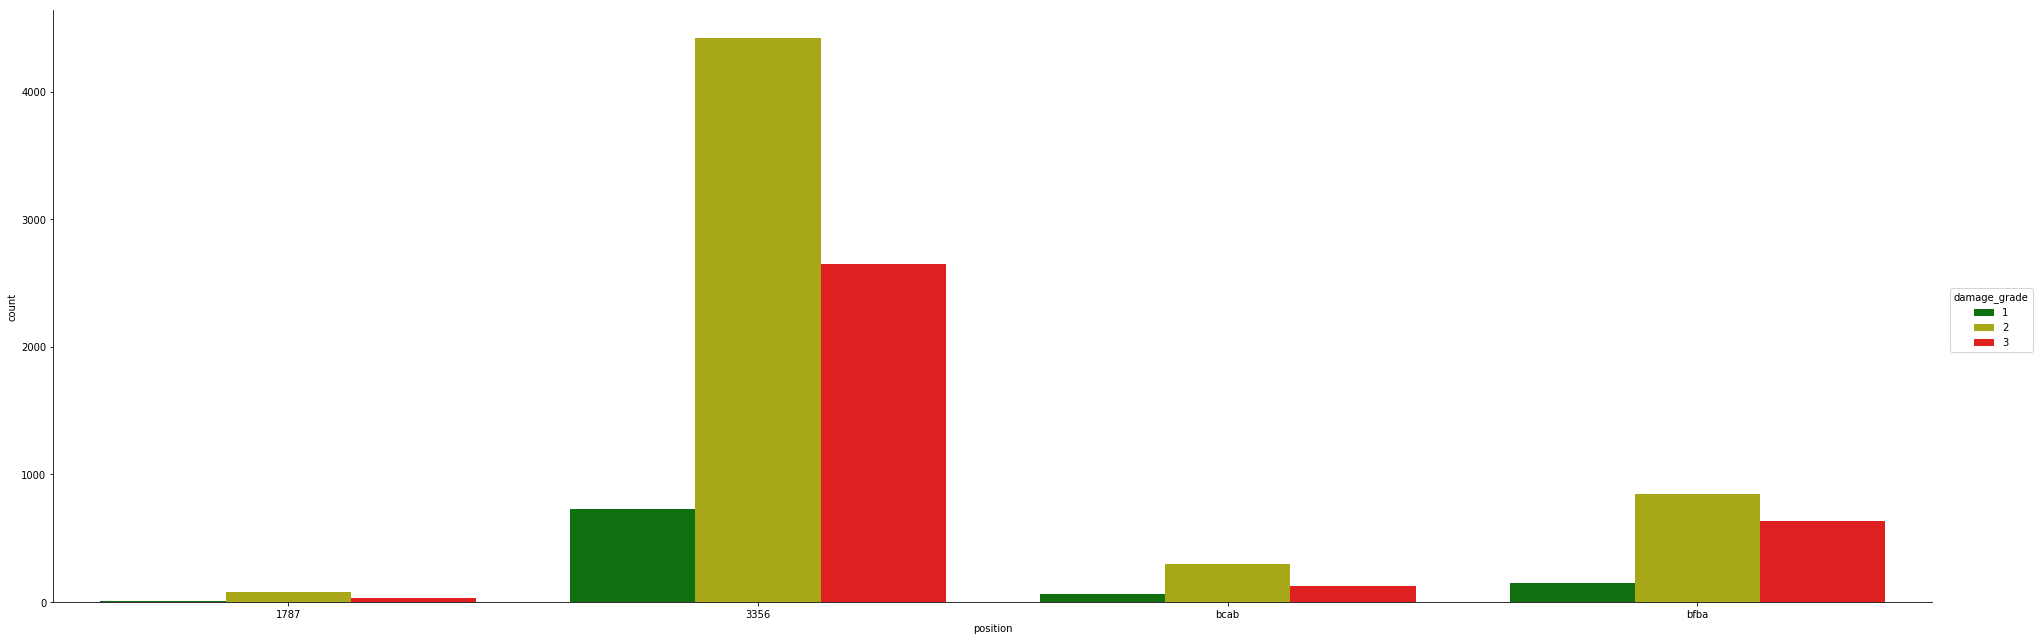

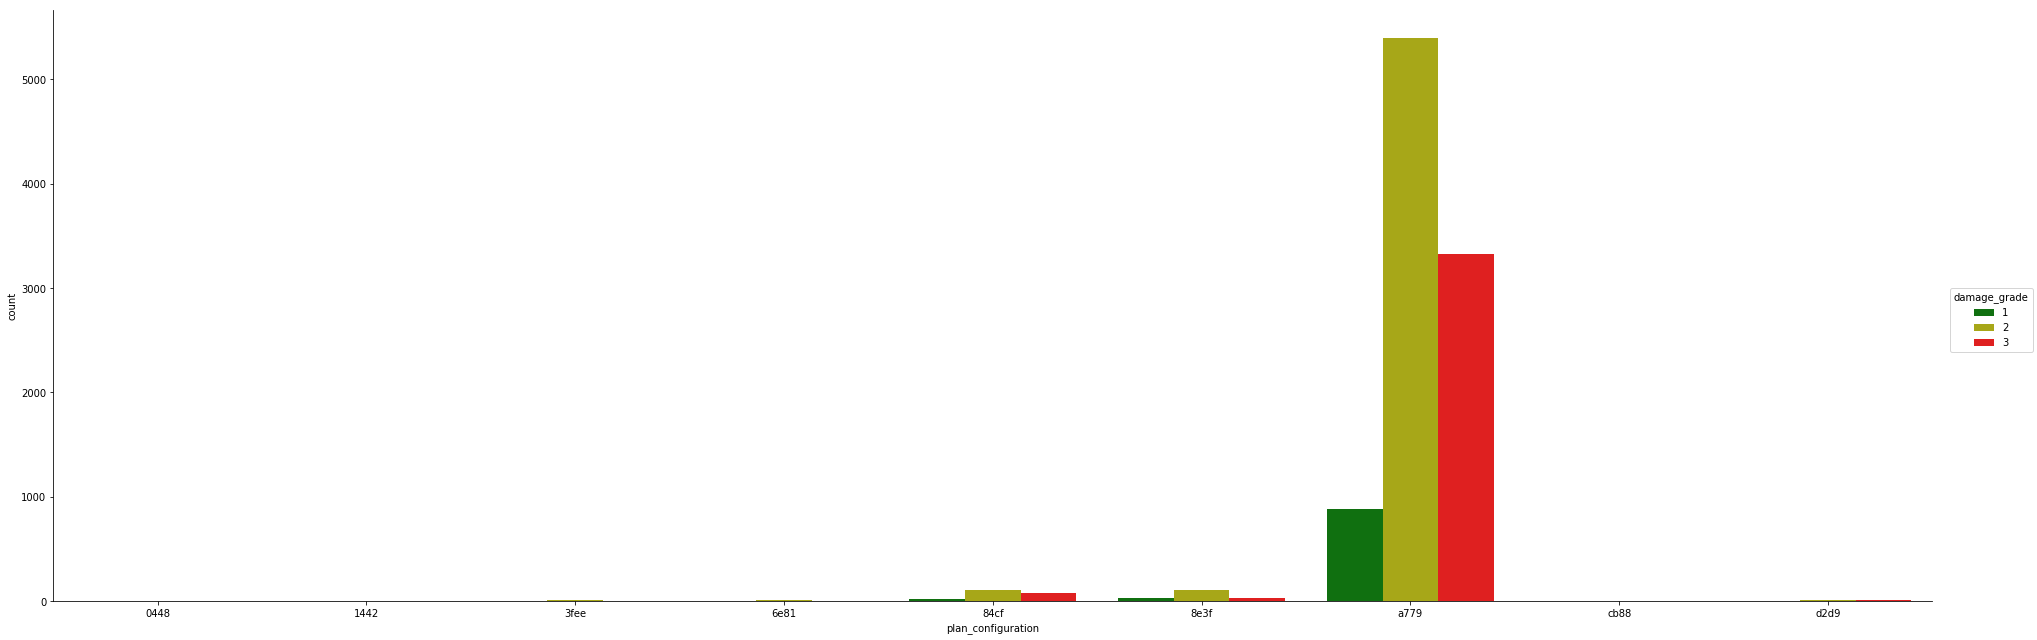

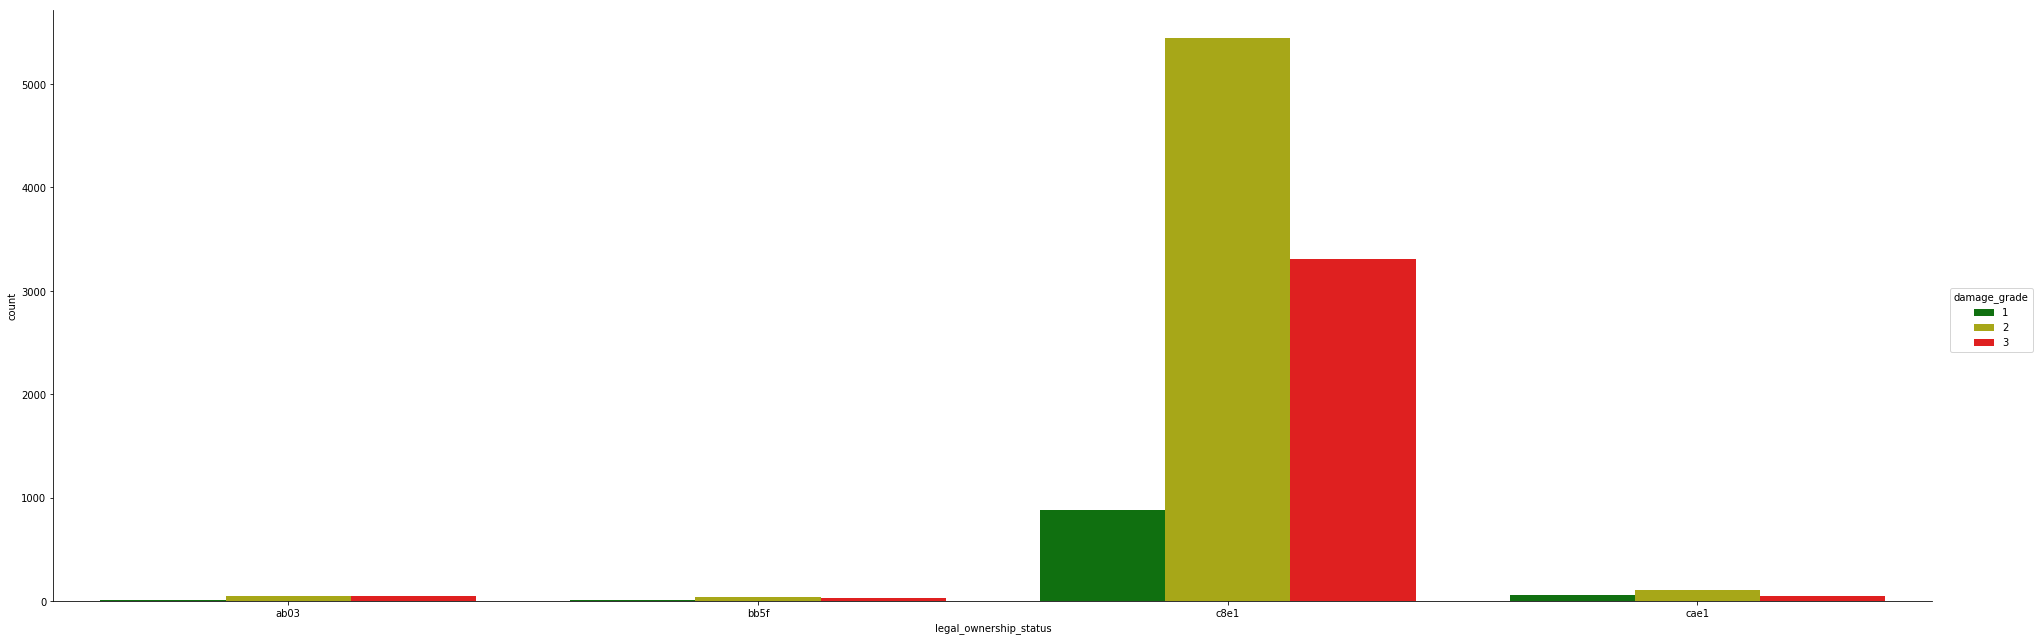

In [173]:
%matplotlib inline

for cat in non_geo_cat_columns:
    sns.factorplot(x=cat, hue='damage_grade', data=all_train, kind='count', size=9, aspect=3, palette=['g','y','r'])

In [174]:
intcorr = all_train[integer_variables].corr()
print(intcorr)

                     count_floors_pre_eq       age      area    height  \
count_floors_pre_eq             1.000000  0.100241  0.110125  0.771249   
age                             0.100241  1.000000 -0.003627  0.079549   
area                            0.110125 -0.003627  1.000000  0.211601   
height                          0.771249  0.079549  0.211601  1.000000   
count_families                  0.099333  0.022957  0.083119  0.066099   

                     count_families  
count_floors_pre_eq        0.099333  
age                        0.022957  
area                       0.083119  
height                     0.066099  
count_families             1.000000  


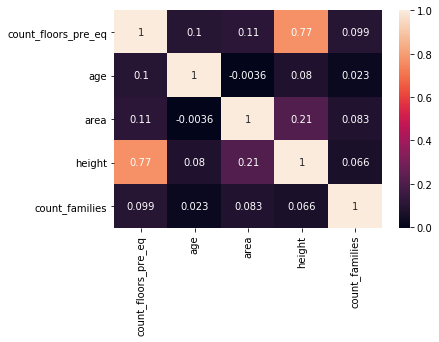

In [175]:
sns.heatmap(intcorr, annot=True)

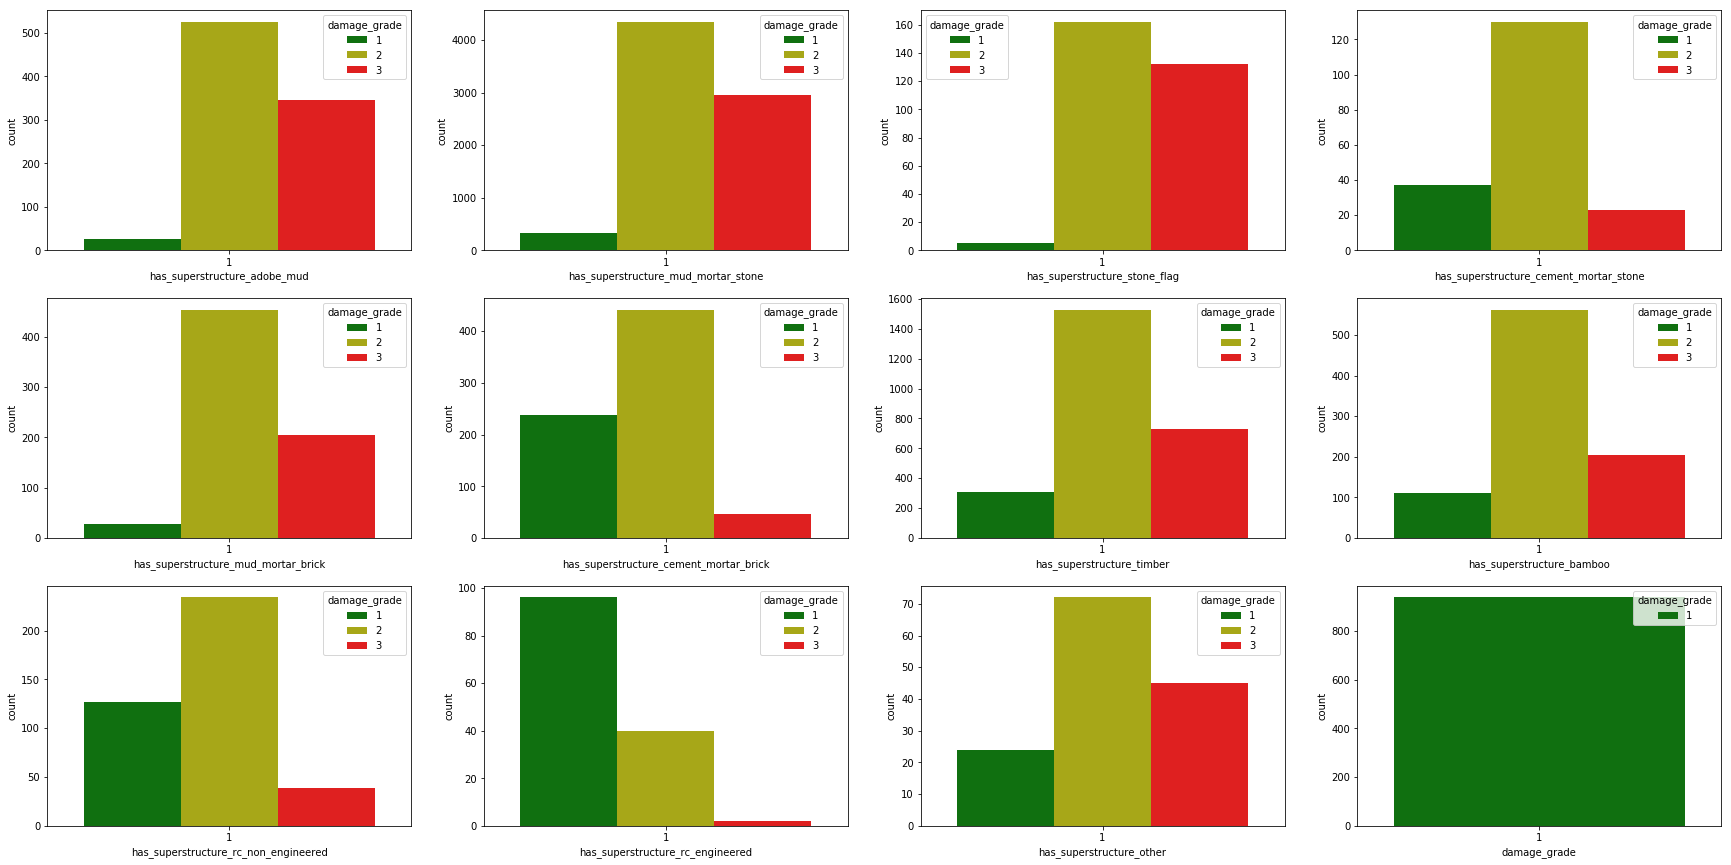

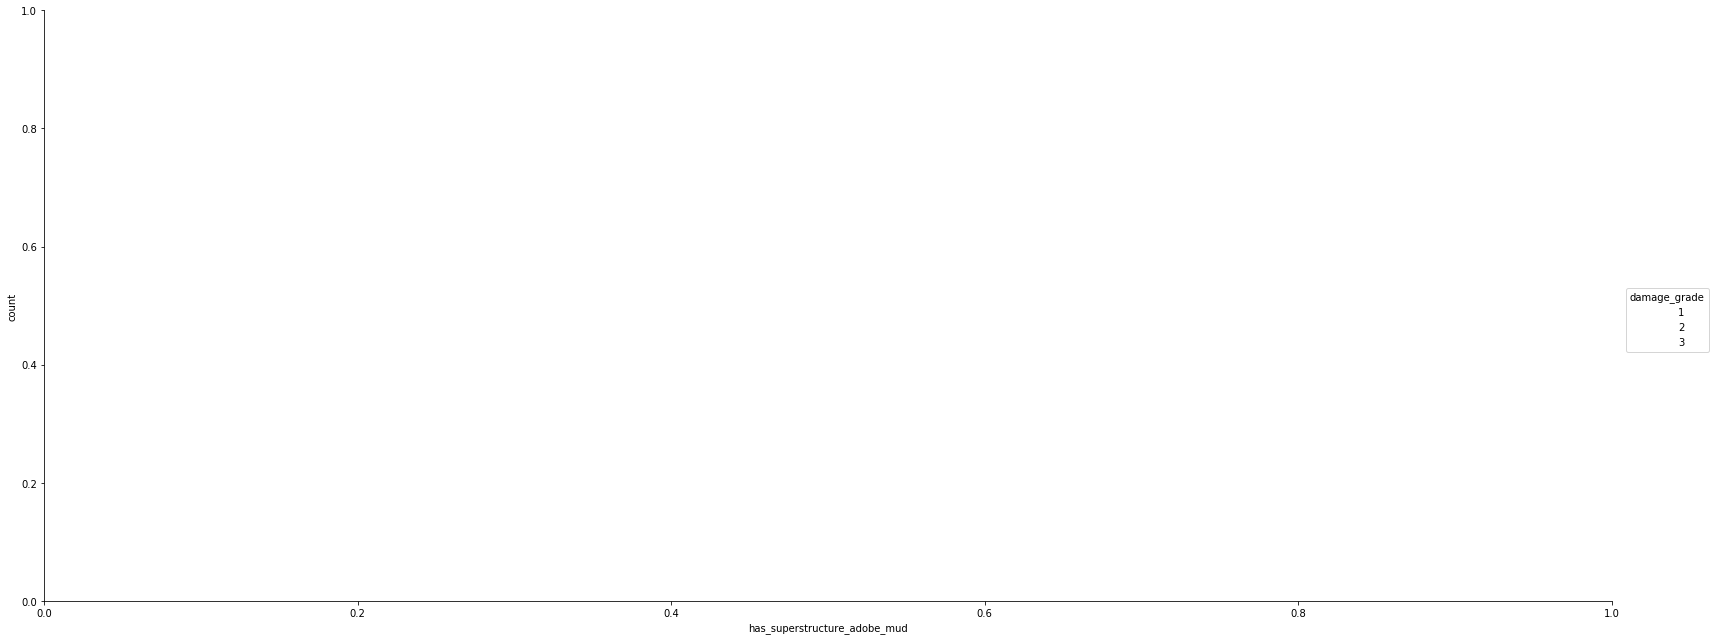

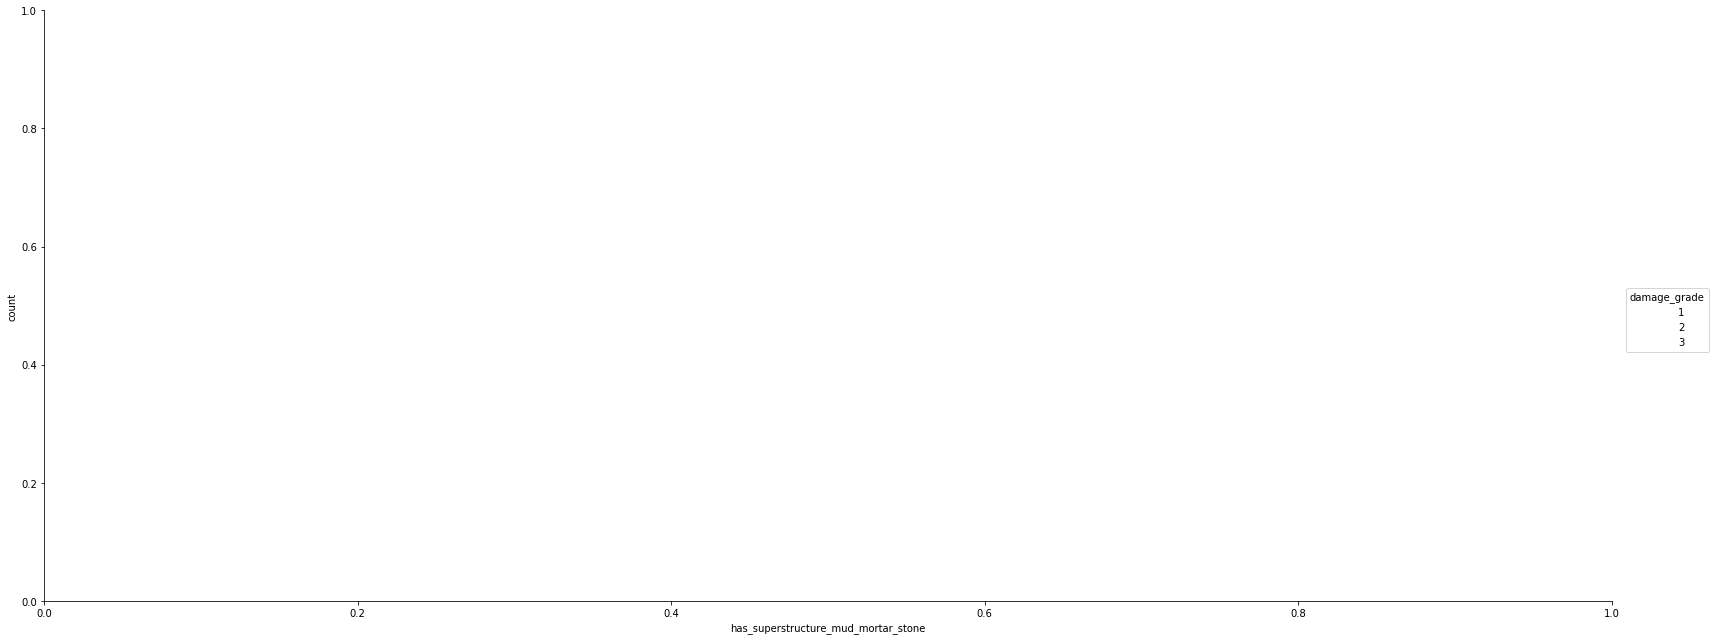

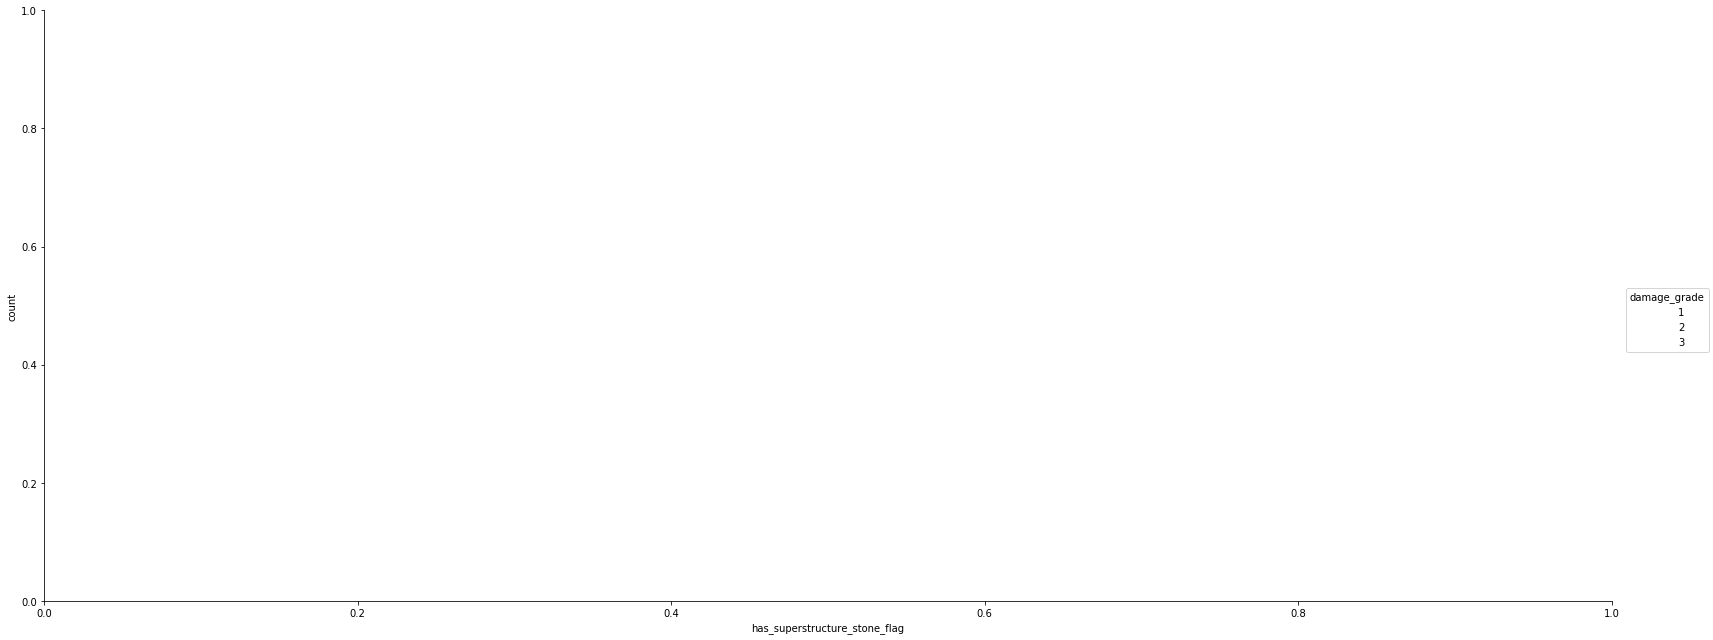

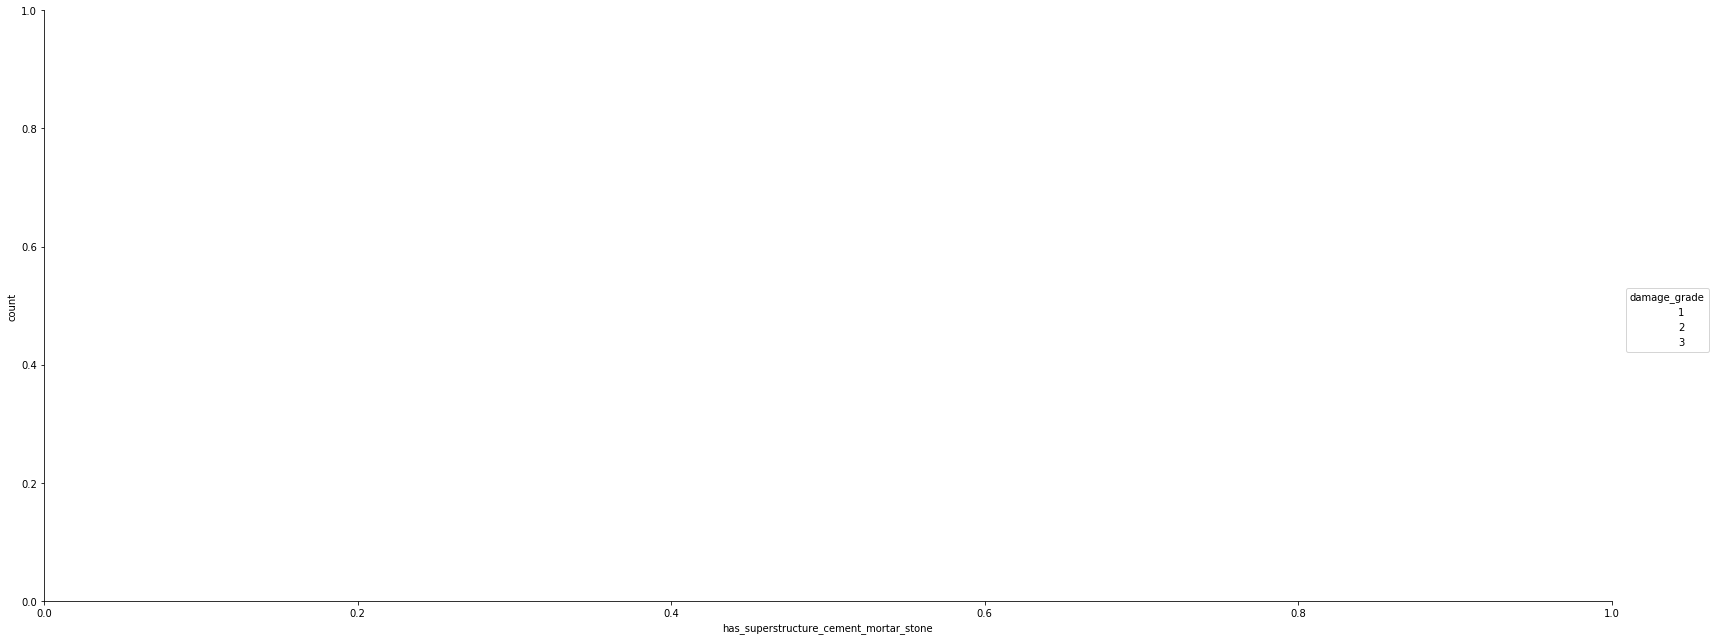

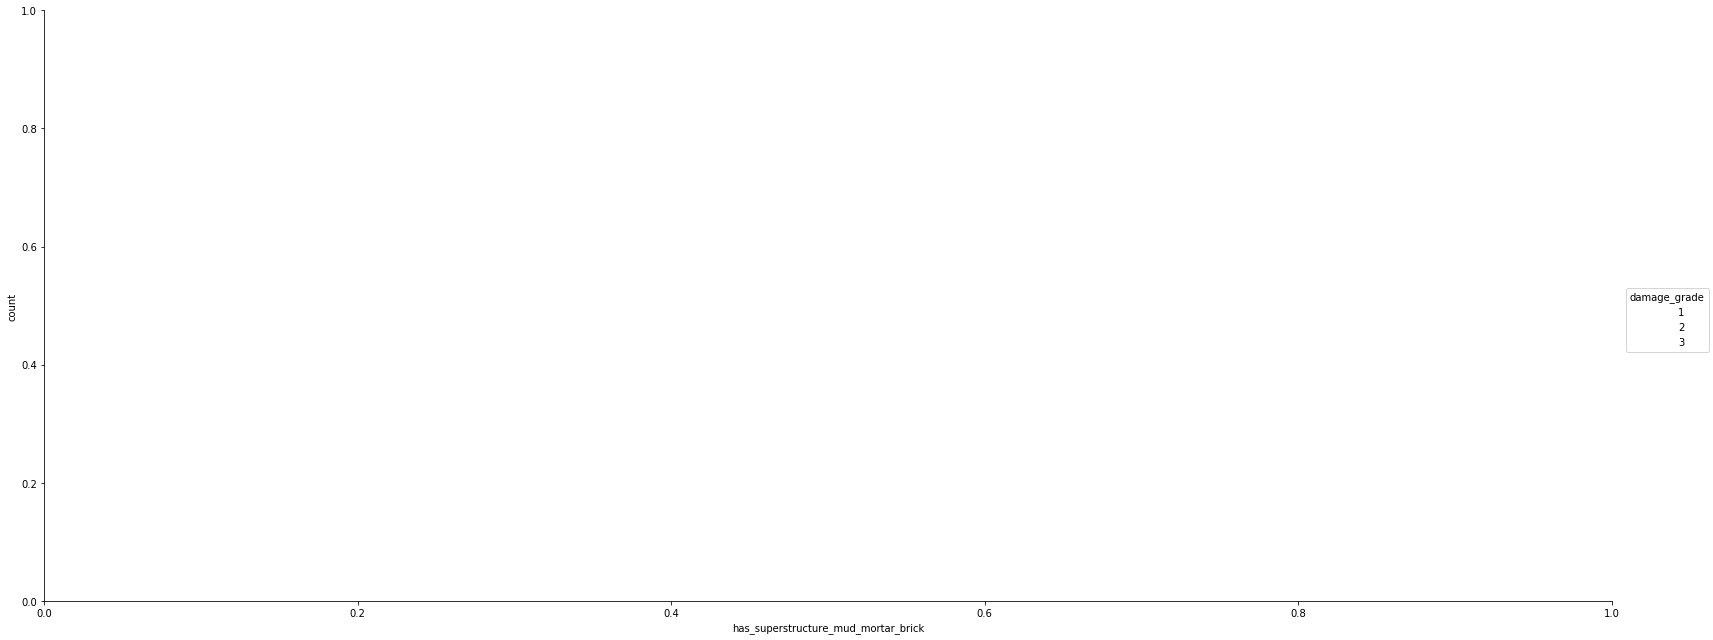

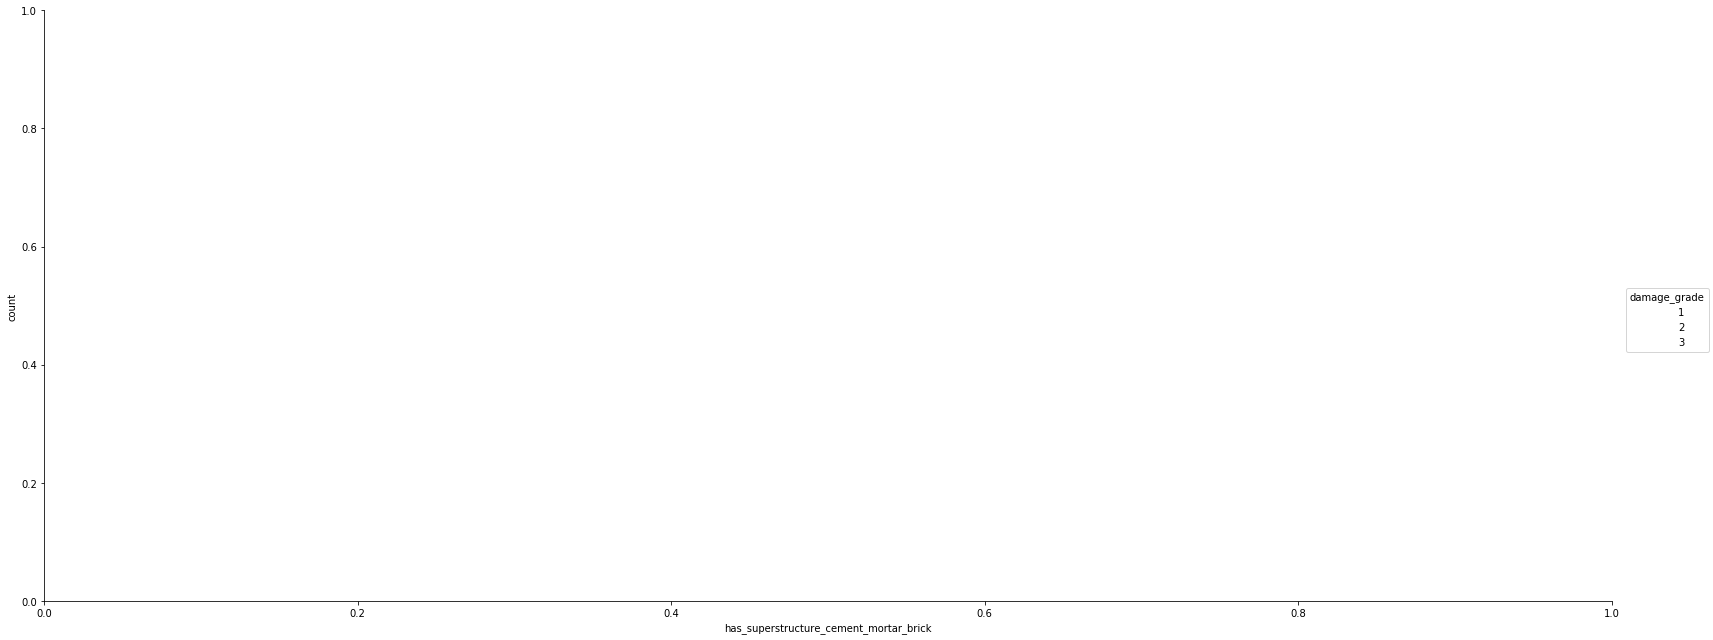

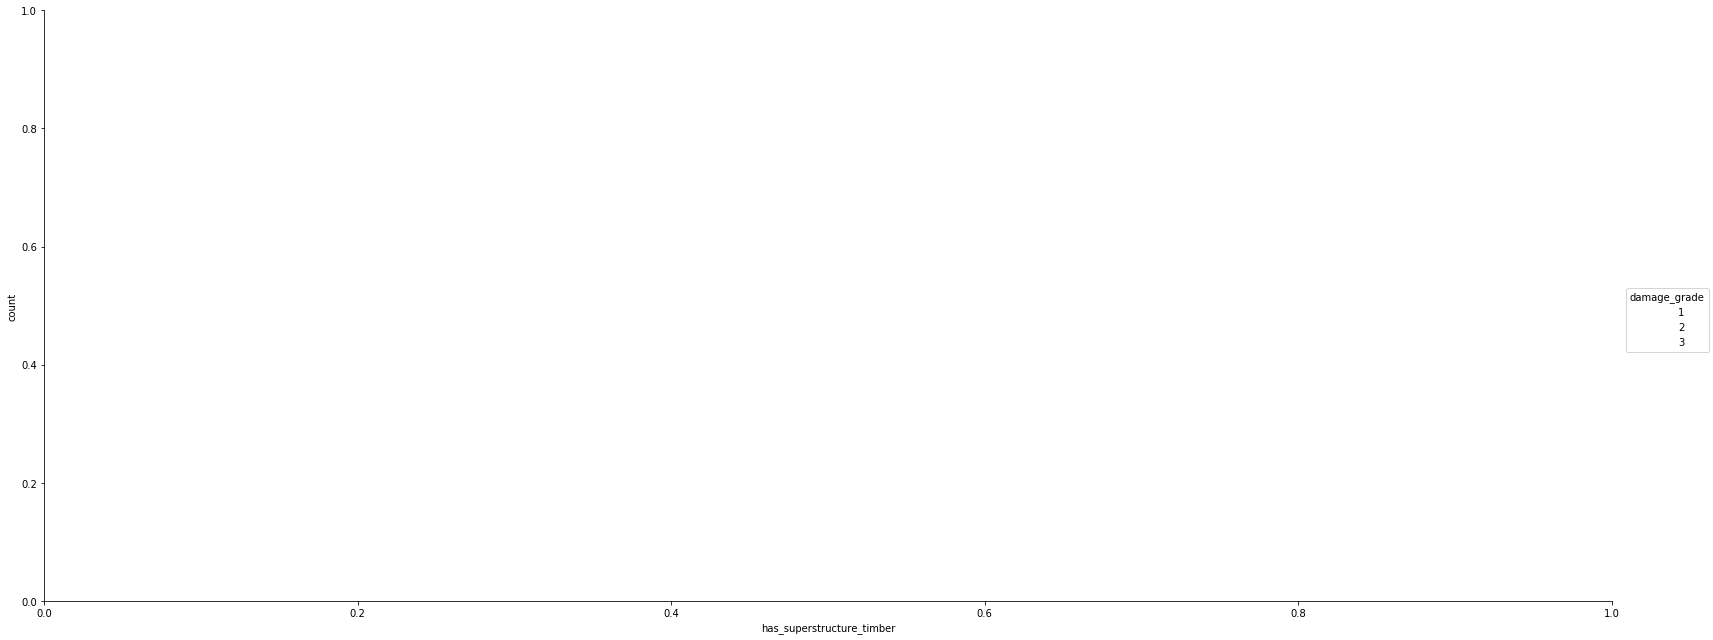

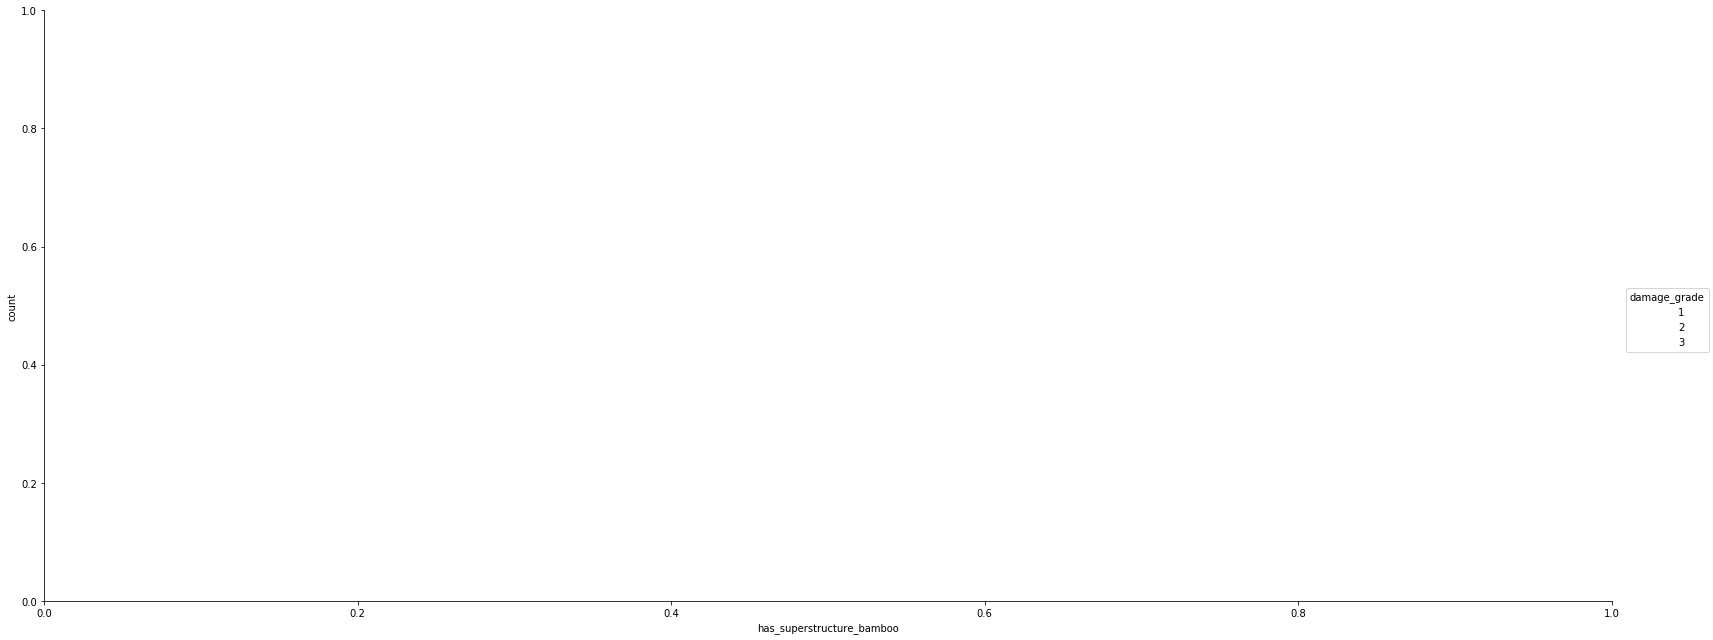

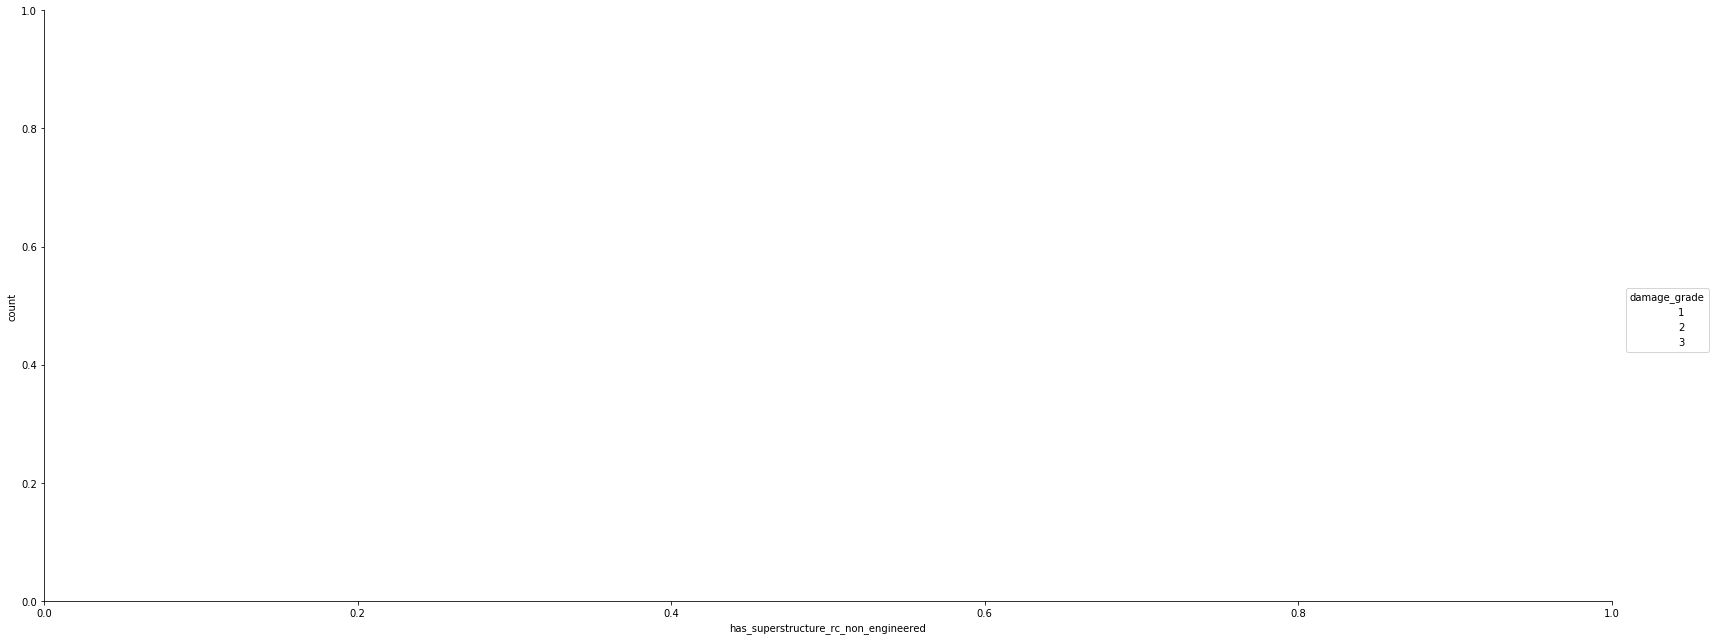

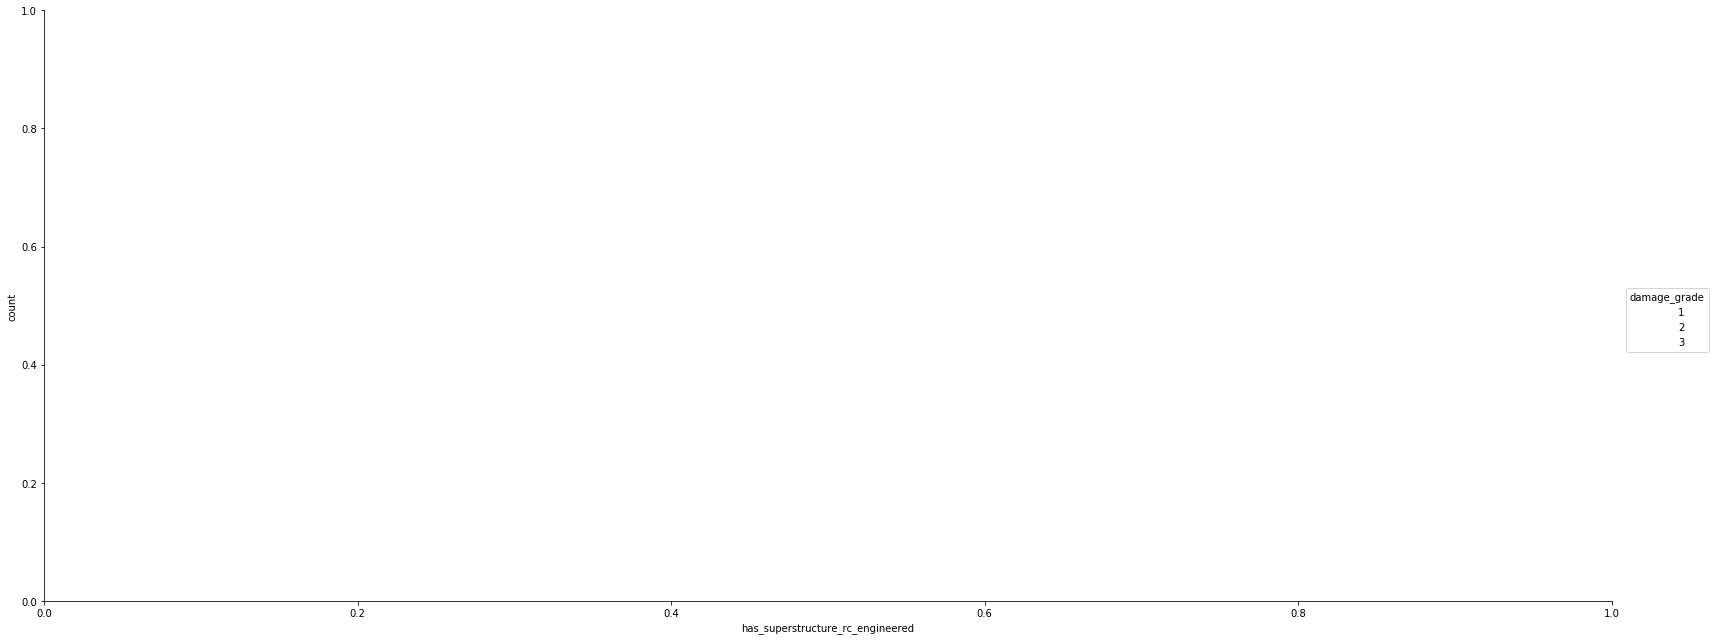

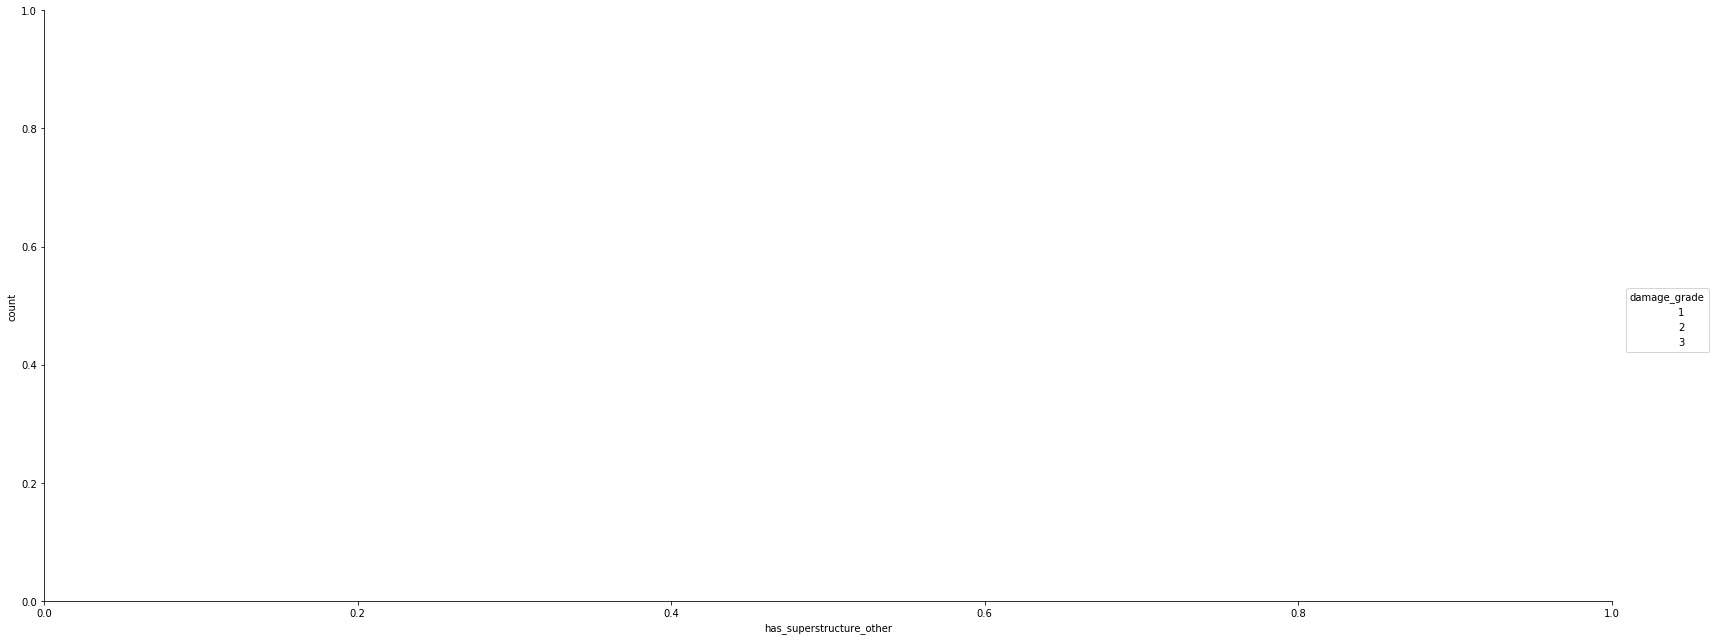

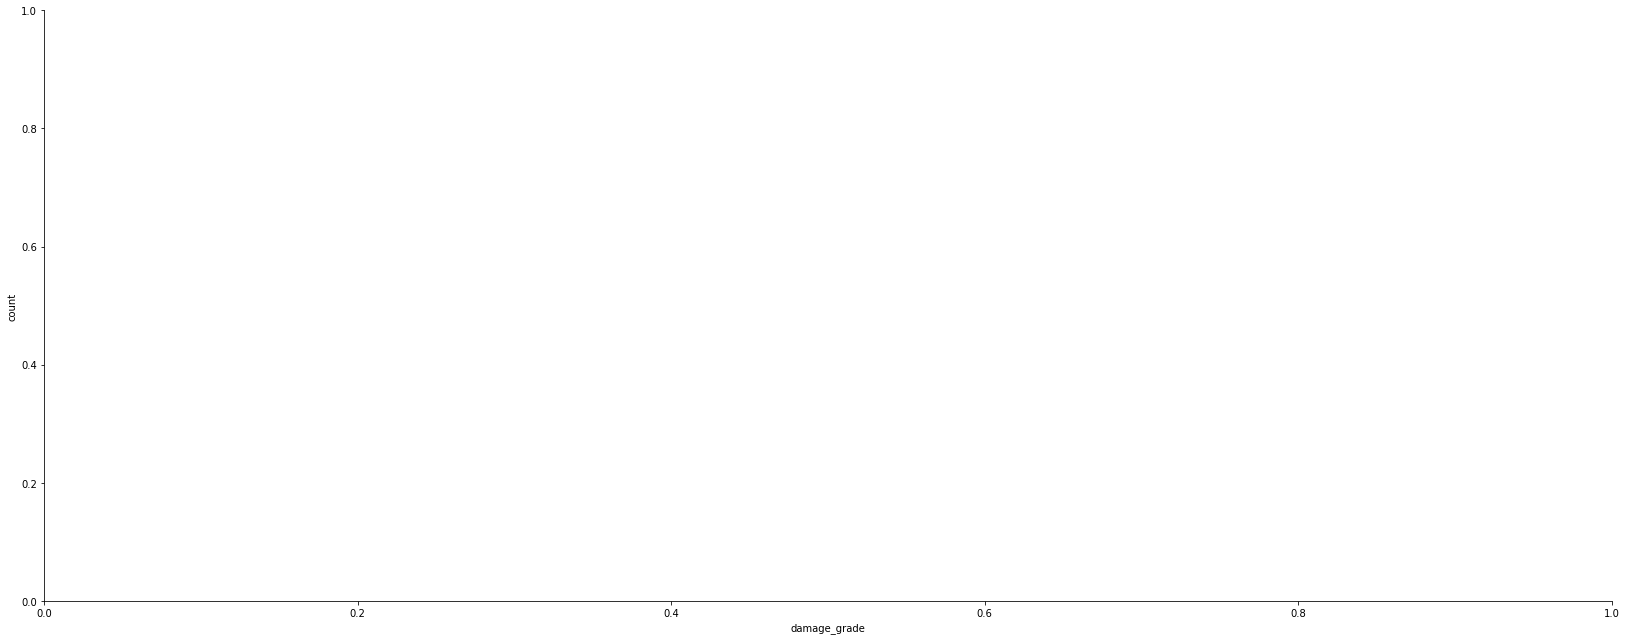

In [176]:
f, axes = plt.subplots(3, 4, figsize=(30, 15))
count = 0

#%matplotlib inline

for x in range(0,3):
    for y in range(0,4):
        sns.factorplot(x=superstructure_variables[count], hue='damage_grade', 
                       data=all_train.loc[all_train[superstructure_variables[count]] == 1,superstructure_variables], 
                       kind='count', size=9, aspect=2.5, palette=['g','y','r'], ax=axes[x, y])
        count = count + 1



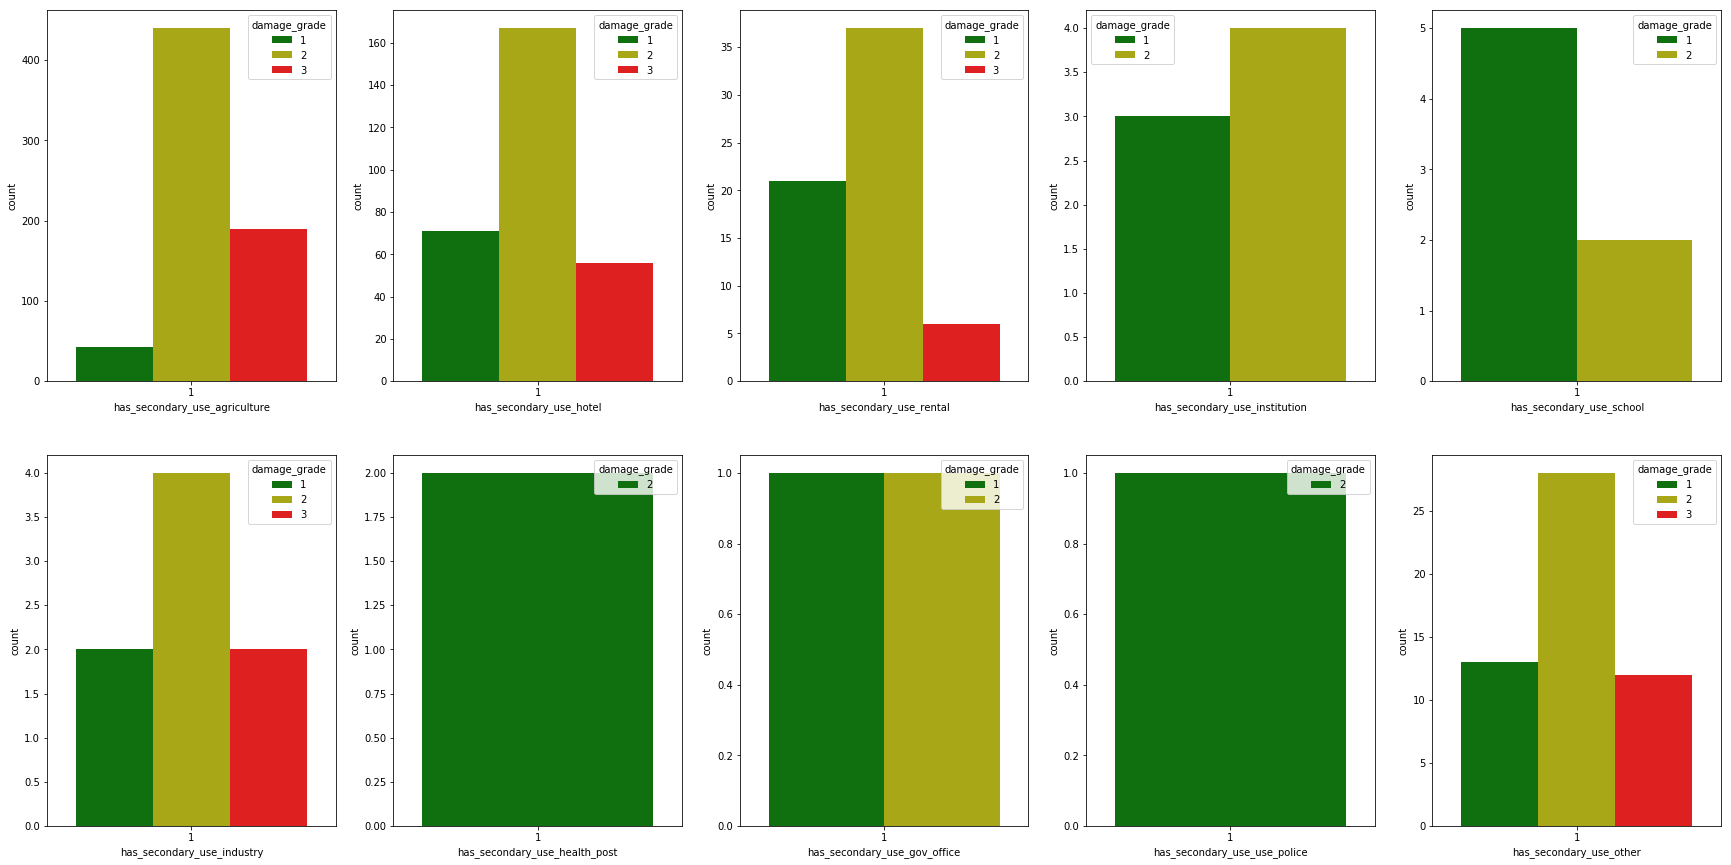

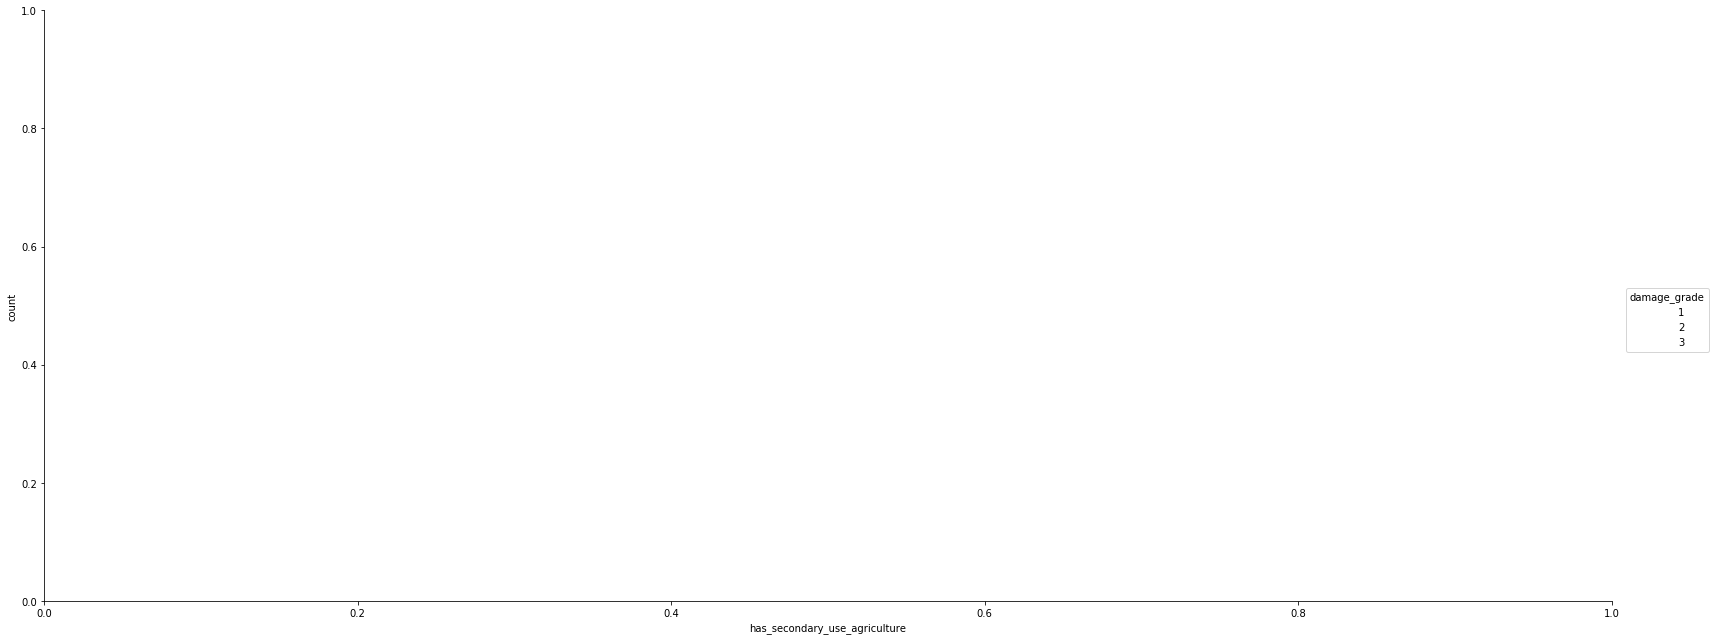

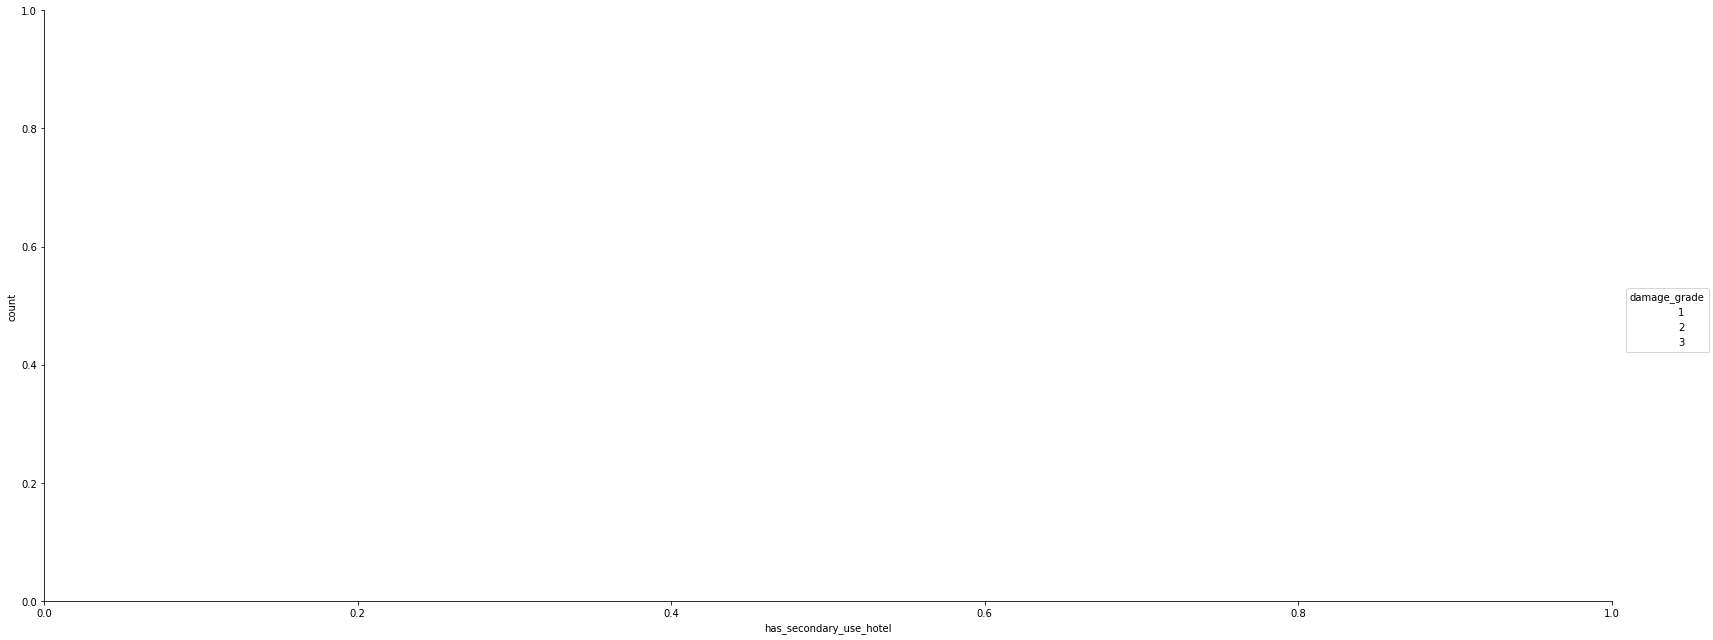

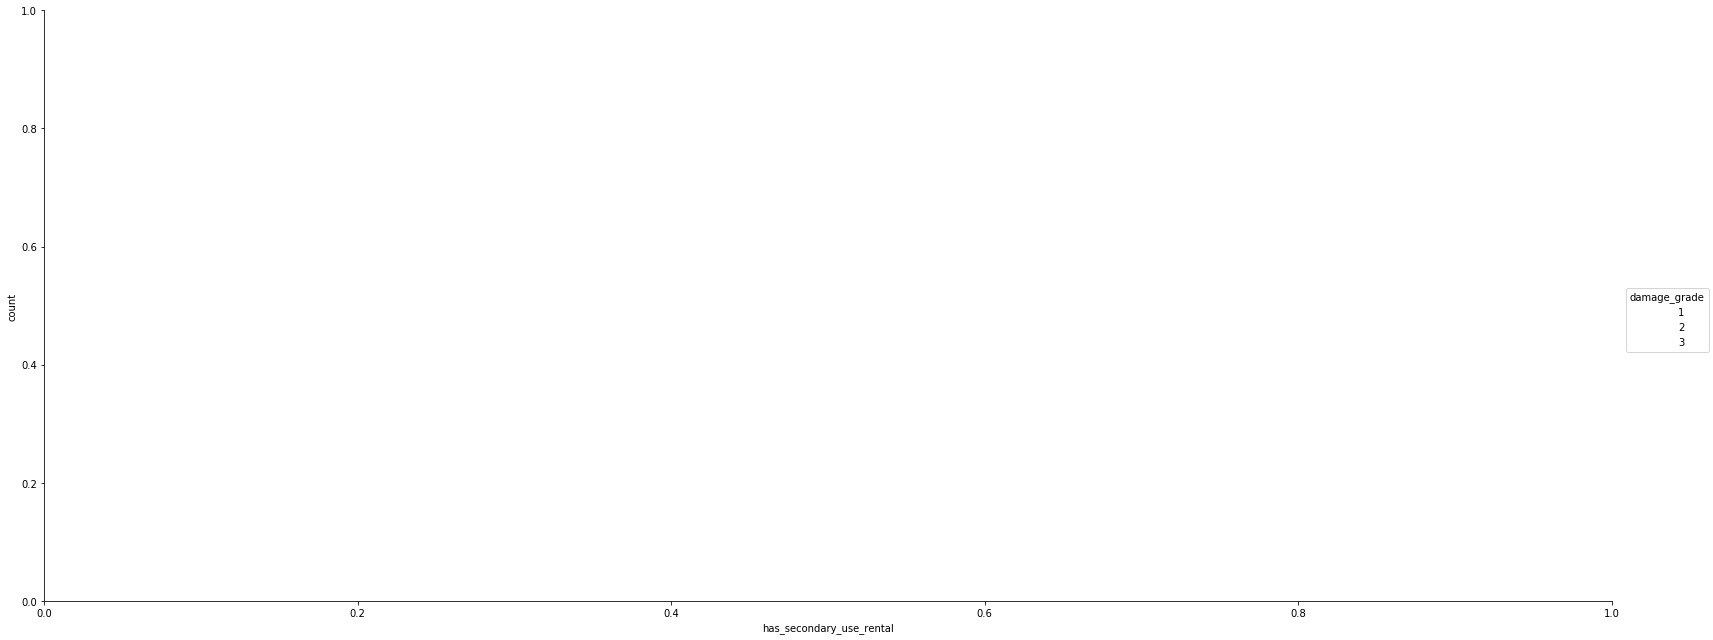

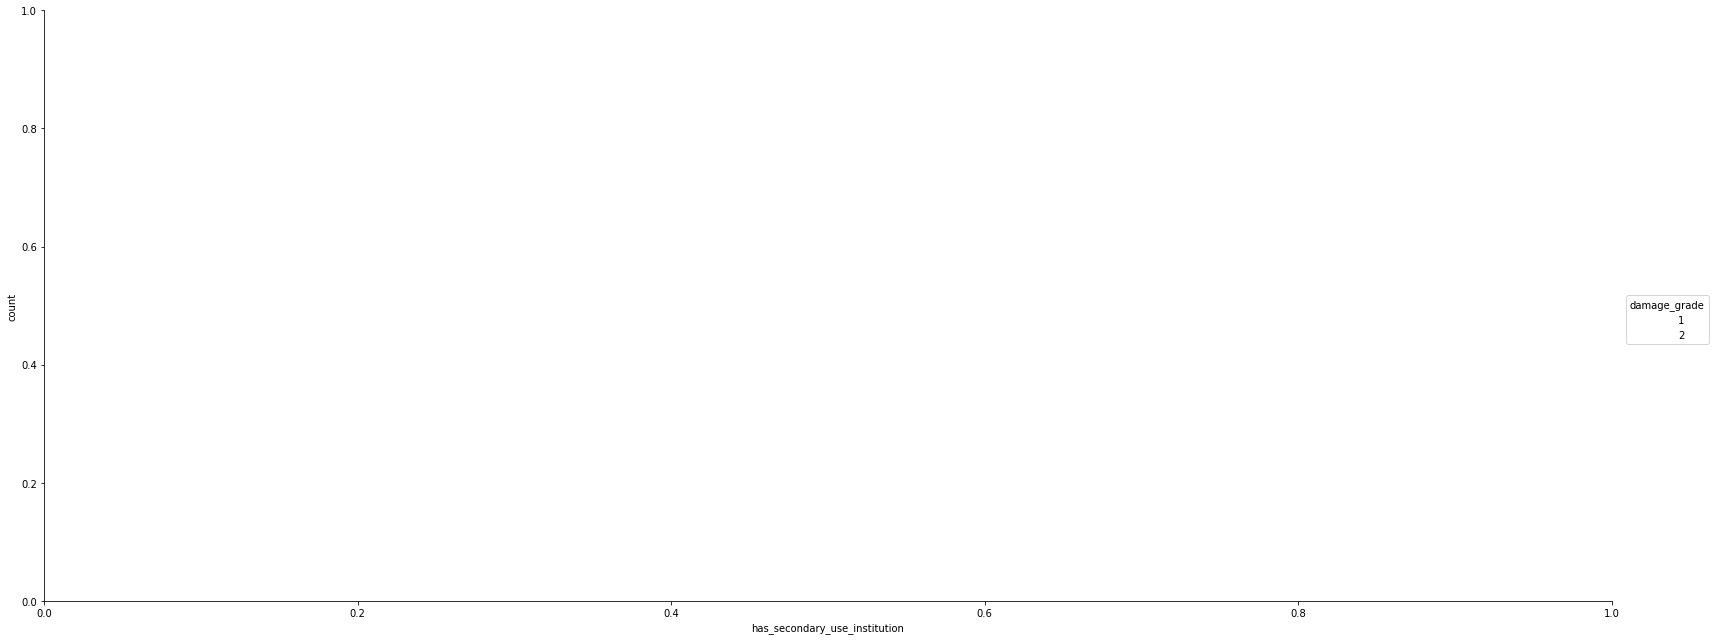

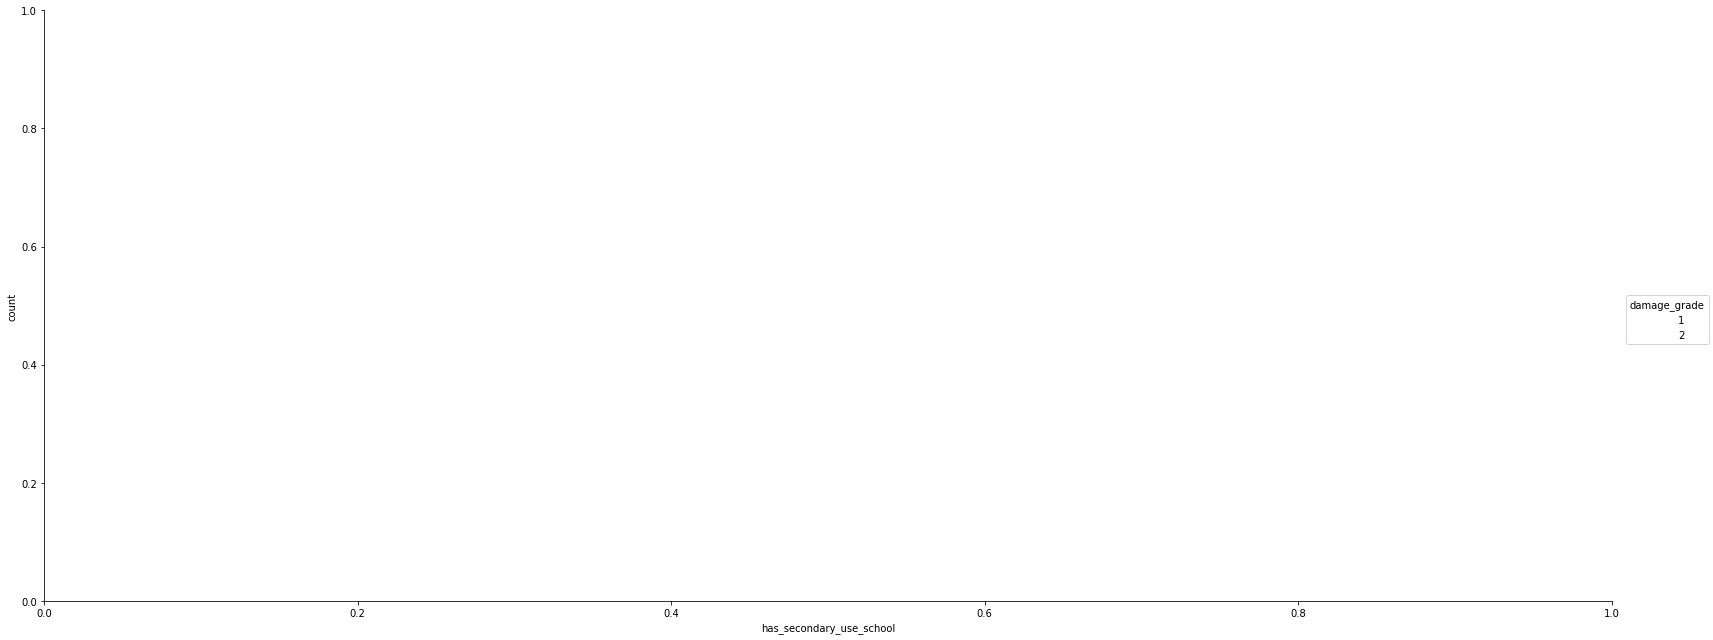

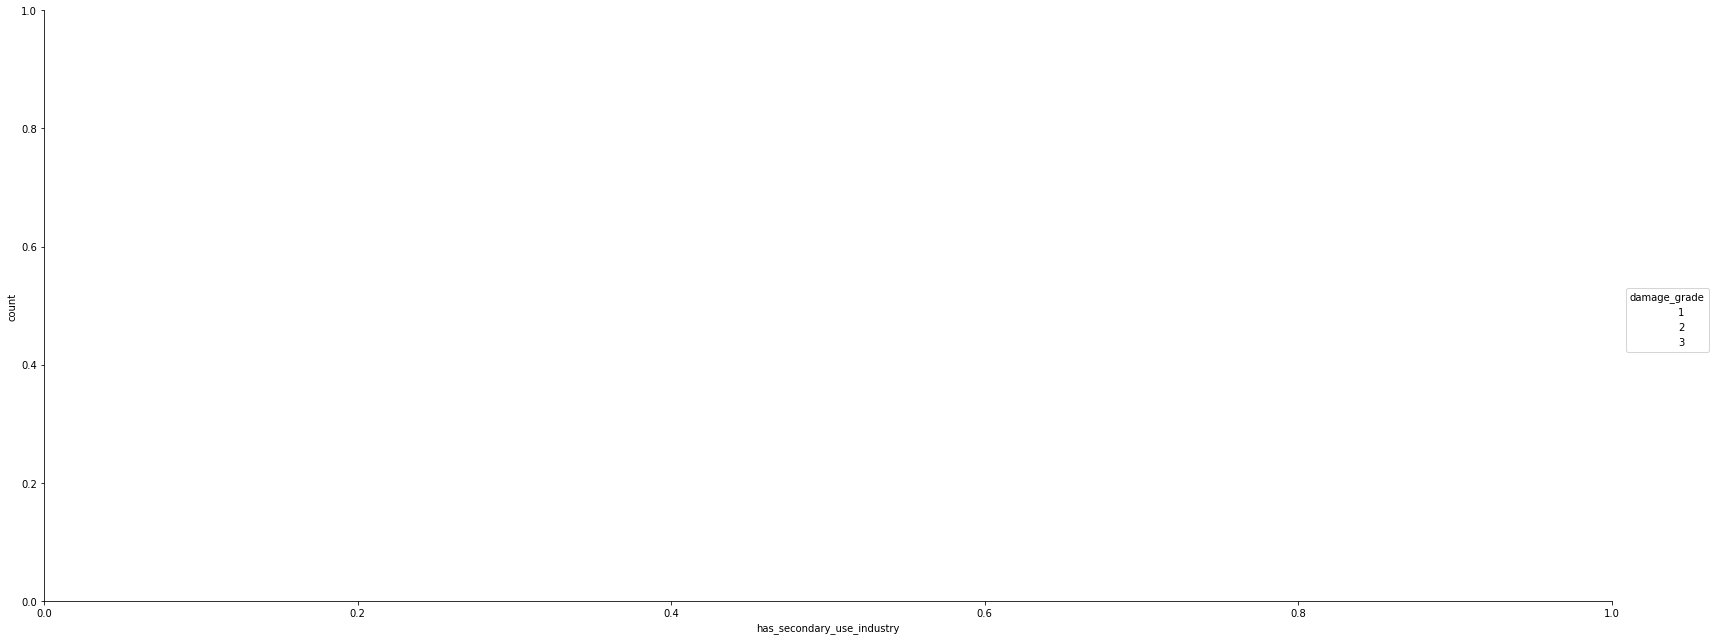

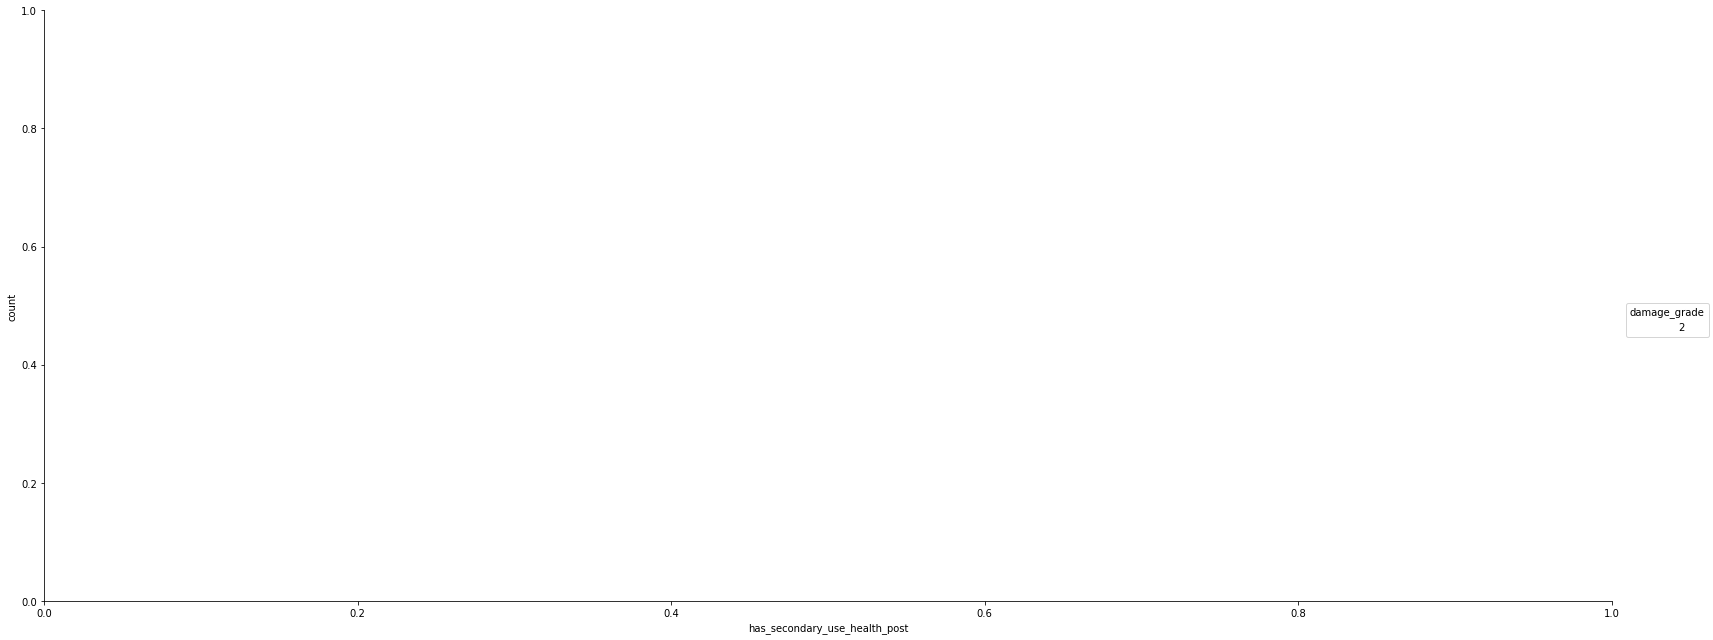

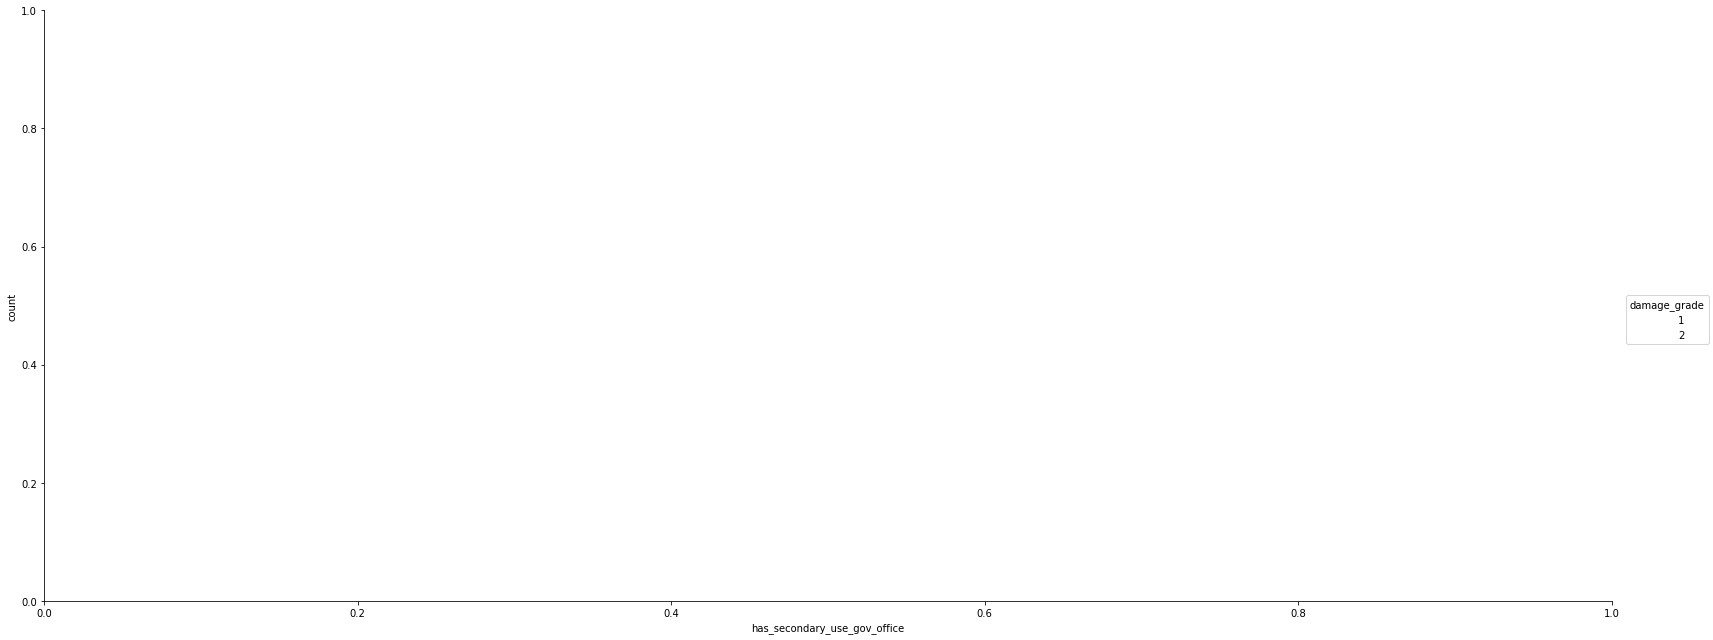

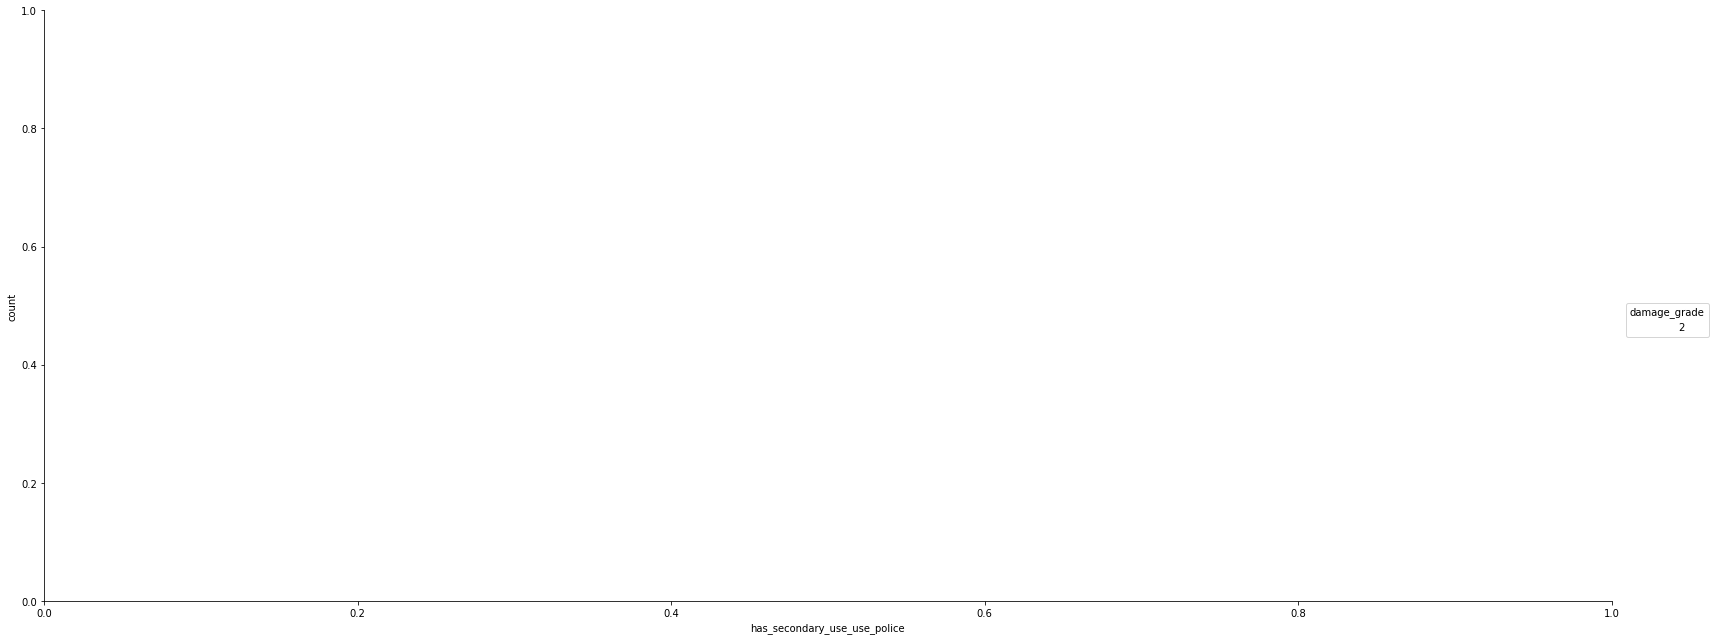

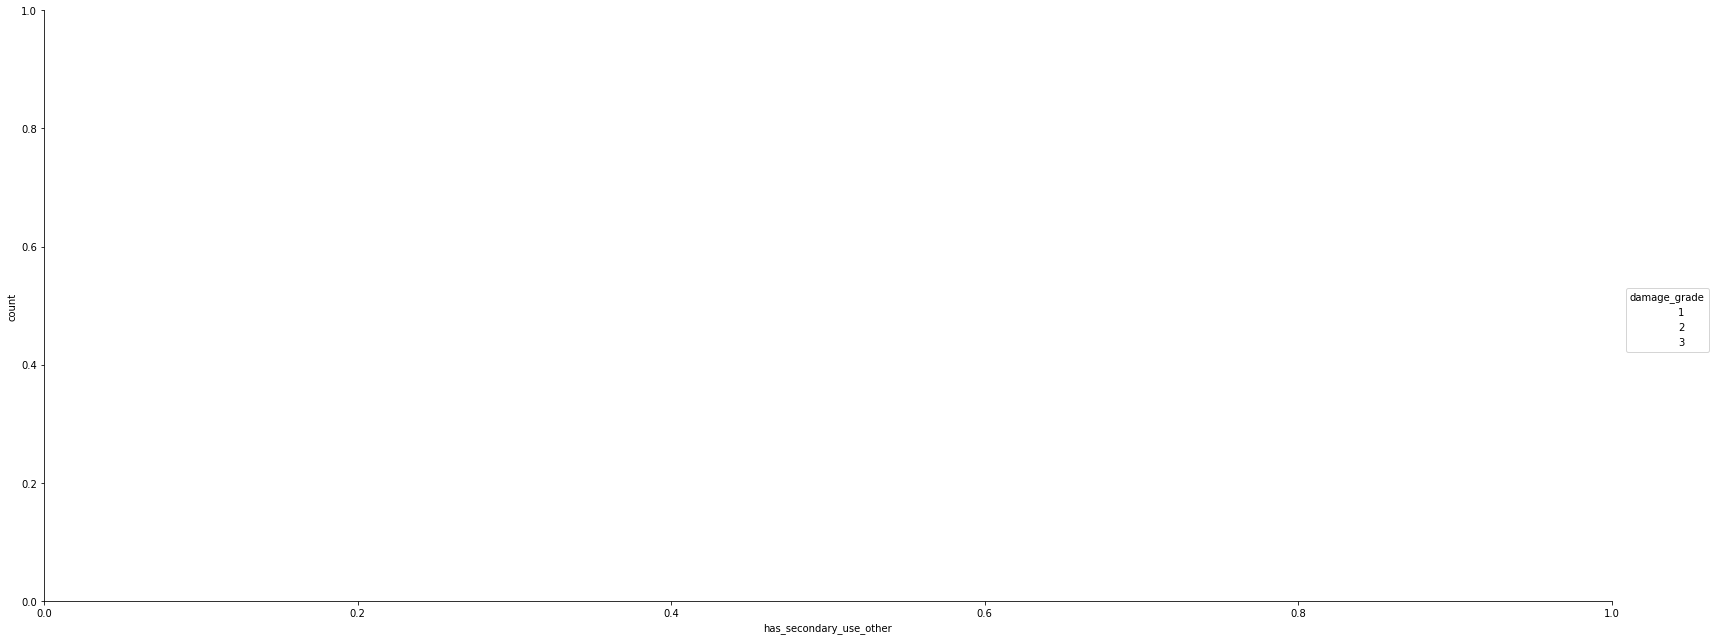

In [177]:
f, axes = plt.subplots(2, 5, figsize=(30, 15))
count = 0

#%matplotlib inline

for x in range(0,2):
    for y in range(0,5):
        sns.factorplot(x=secuse_variables[count], hue='damage_grade', 
                       data=all_train.loc[all_train[secuse_variables[count]] == 1,secuse_variables], 
                       kind='count', size=9, aspect=2.5, palette=['g','y','r'], ax=axes[x, y])
        count = count + 1